# AGU25 figures
Multi-panel labeled figures combined from CYGNSS notebooks; single-panel/plot_region outputs removed.


In [1]:
from pathlib import Path
import sys

# Ensure repo utils are on path and import region bounds/helpers
def find_repo_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if (p / '.git').exists():
            return p
    return start

here = Path(__file__).resolve().parent if '__file__' in globals() else Path.cwd()
repo_root = find_repo_root(here)
sys.path.append(str(repo_root / 'common' / 'python' / 'plotting'))
from geospatial_plotting import REGION_BOUNDS, load_ease_grid, build_ease_grid_mapping


Saved:
 - combined_networks_surf_root_overlay.png
 - combined_networks_delta_from_control_overlay.png


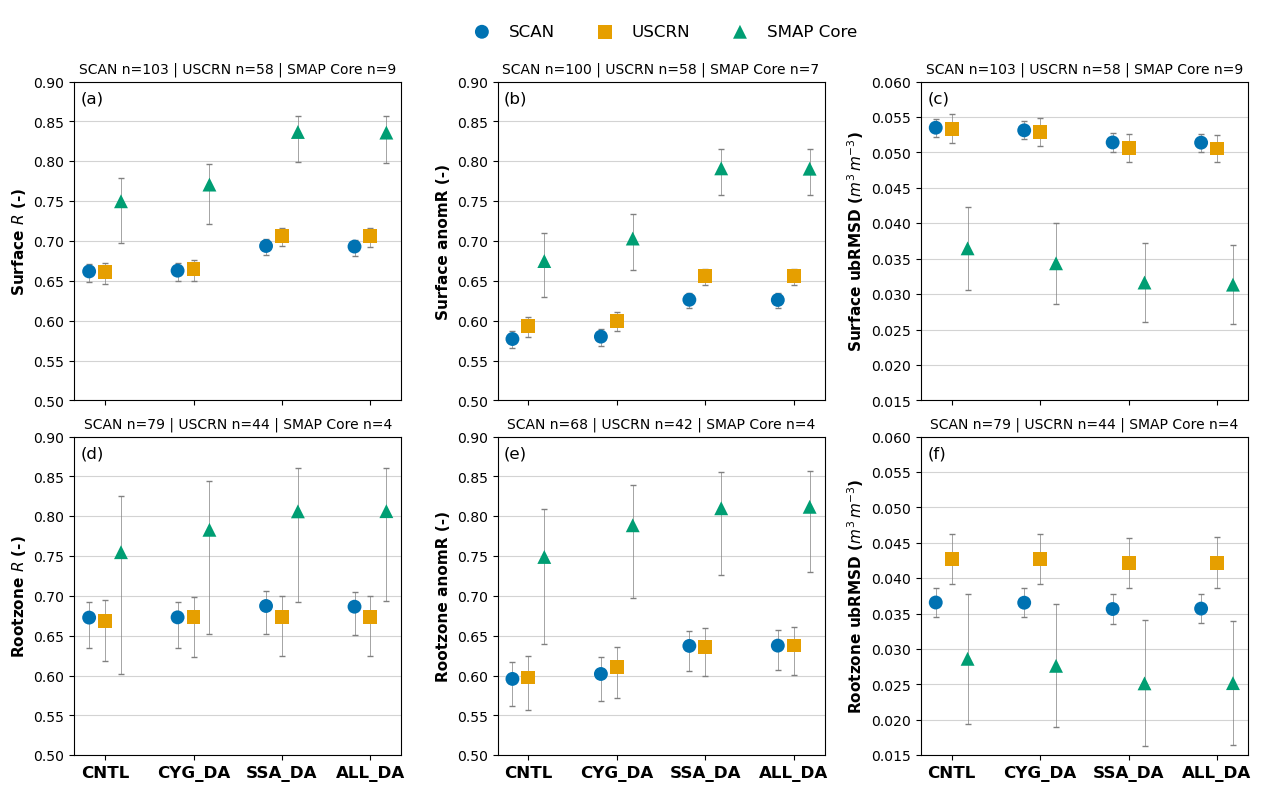

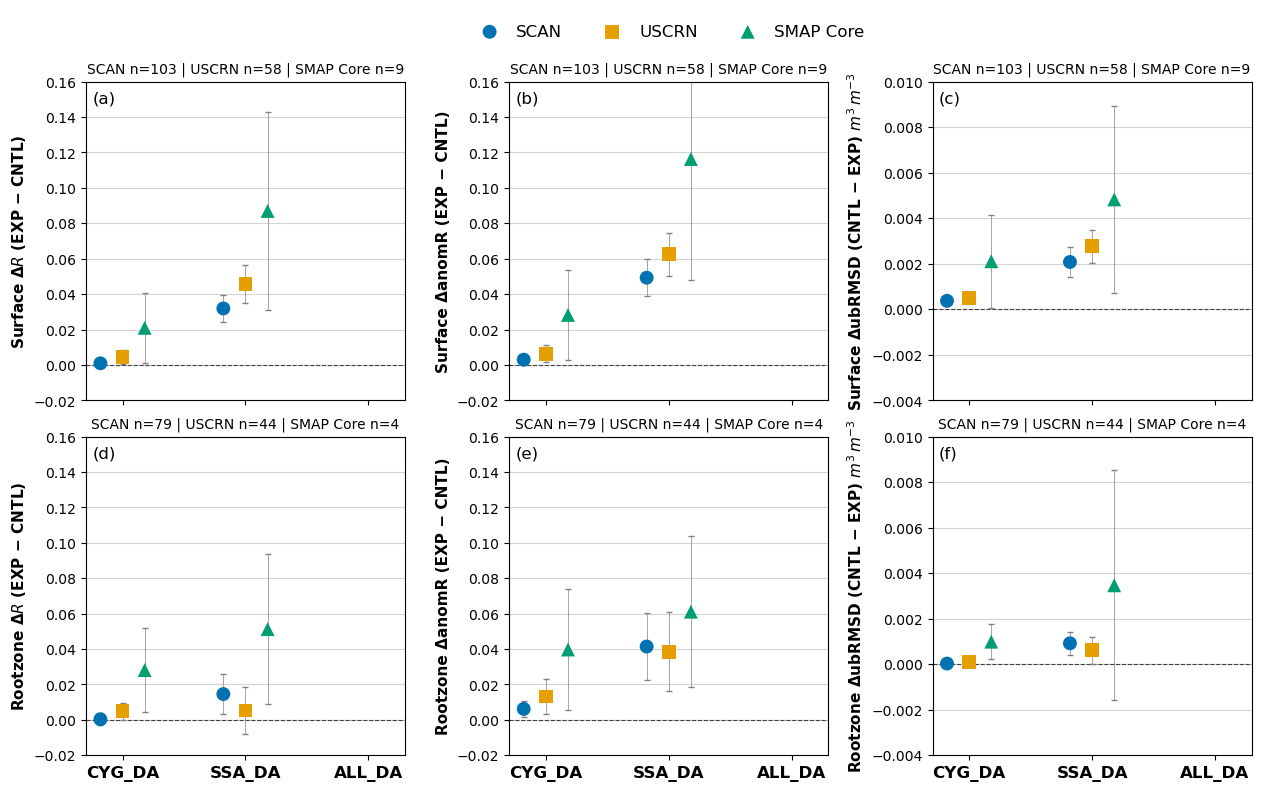

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.stats import t
from pathlib import Path

# ===============================
# CONFIG
# ===============================

DATA_DIR = Path("/Users/amfox/Desktop/GEOSldas_diagnostics/test_data")

BASE_DIR = Path(DATA_DIR, "CYGNSS_Experiments/Evaluation/InSitu/output")

# Experiments (order -> x-axis)
# experiment_names = ["OLv8_M36_cd", "DAv8_M36_cd", "DAv8_M36_cd_ssa", "DAv8_M36_cd_all"]
# expt_labels = ["CNTL", "CYG_DA", "SSA_DA", "ALL_DA"]

experiment_names = ["OLv8_M36_cd", "DAv8_M36_cd", "DAv8_M36_cd_ssa_fixed", "DAv8_M36_cd_all_fixed"]
expt_labels = ["CNTL", "CYG_DA", "SSA_DA", "ALL_DA"] 

# Networks to combine: (insitu_tag_in_filename, label)
networks = [
    ("_SCAN_SM_1d_c1234smv_6yr", "SCAN"),
    ("_USCRN_SM_1d_c1234smv_6yr", "USCRN"),
    ("_CalVal_M33_SM_1d__6yr", "SMAP Core"),
]

# Plot look
title_fs = 15
label_fs = 11
tick_fs  = 10
legend_fs = 12
dot_size = 100
capsize = 2

# Okabe–Ito palette (3 distinct)
palette = {"SCAN": "#0072B2", "USCRN": "#E69F00", "SMAP Core": "#009E73"}
markers = {"SCAN": "o", "USCRN": "s", "SMAP Core": "^"}

# Panels and y-lims for raw means
panel_info_means = [
    ("R",      r"$R$ (-)",                (0.50, 0.90)),
    ("anomR",  r"anomR (-)",              (0.50, 0.90)),
    ("ubRMSE", r"ubRMSD ($m^3\,m^{-3}$)", (0.015, 0.060)),
]

# Panels and y-lims for deltas (tweak if needed)
panel_info_delta = [
    ("R",      r"Δ$R$ (EXP − CNTL)",                      (-0.02, 0.16)),
    ("anomR",  r"ΔanomR (EXP − CNTL)",                    (-0.02, 0.16)),
    ("ubRMSE", r"ΔubRMSD (CNTL − EXP) $m^3\,m^{-3}$",     (-0.004, 0.010)),
]

# ===============================
# HELPERS
# ===============================
def reduce_metric_means_ci(arr, lo, up):
    """
    Compute mean across sites and CI magnitudes as in your original script:
    CI_magnitudes ≈ mean(LO or UP)/sqrt(N_nonNaN).
    Returns:
      mean: (depth,)
      ci_mag: (2, depth)  (lower, upper) magnitudes (non-negative)
      n: (depth,) integer counts of non-NaN sites
    """
    mean = np.nanmean(arr, axis=0)                  # (depth,)
    n = np.sum(~np.isnan(arr), axis=0)              # (depth,)
    denom = np.sqrt(np.maximum(n, 1))
    ci_lo = np.nanmean(lo, axis=0) / denom
    ci_up = np.nanmean(up, axis=0) / denom
    ci_mag = np.vstack([np.abs(ci_lo), np.abs(ci_up)])
    return mean, ci_mag, n

def paired_delta_stats(arr_cntl, arr_exp, up_is_better=True, alpha=0.05):
    """
    Paired per-site differences and t-intervals (statistically correct).
    arr_cntl, arr_exp: (sites, depth)
    up_is_better=True -> Δ = EXP - CNTL; False -> Δ = CNTL - EXP (e.g., ubRMSE)
    Returns:
      mean_delta: (depth,)
      ci_half:   (depth,) symmetric t CI half-width (magnitude)
      n_eff:     (depth,) paired counts
    """
    sign = +1 if up_is_better else -1
    D = sign * (arr_exp - arr_cntl)                 # (sites, depth)
    # mask to paired non-NaN per depth
    mask = (~np.isnan(arr_cntl)) & (~np.isnan(arr_exp))
    depth = arr_cntl.shape[1]
    mean_delta = np.full(depth, np.nan)
    ci_half = np.full(depth, 0.0)
    n_eff = np.zeros(depth, dtype=int)

    for d in range(depth):
        m = mask[:, d]
        if not np.any(m):
            continue
        di = D[m, d]
        n = di.size
        n_eff[d] = n
        dbar = np.nanmean(di)
        sd = np.nanstd(di, ddof=1) if n > 1 else 0.0
        se = sd / np.sqrt(max(n, 1))
        k = t.ppf(1 - alpha/2, df=max(n-1, 1))
        mean_delta[d] = dbar
        ci_half[d] = k * se
    return mean_delta, ci_half, n_eff

def plot_overlay(
    means_dict, cis_dict, Ns_dict, panel_info, outfile,
    title_suffix="", expt_idx=None, x_tick_labels=None
):
    """
    means_dict[m]: [net, depth, expt]
    cis_dict[m]:   [net, 2(lo,up), depth, expt]  (magnitudes)
    Ns_dict[m]:    [net, depth, expt]
    expt_idx:      list/array of experiment indices to plot (default: all)
    x_tick_labels: labels matching expt_idx (default: expt_labels[expt_idx])
    """
    num_networks = len(networks)
    all_idx = np.arange(len(expt_labels))
    if expt_idx is None:
        expt_idx = all_idx
    expt_idx = np.asarray(expt_idx)
    if x_tick_labels is None:
        x_tick_labels = [expt_labels[i] for i in expt_idx]

    fig = plt.figure(figsize=(12.5, 7.8), constrained_layout=True)
    mosaic = [
        ["legend", "legend", "legend"],
        ["s0", "s1", "s2"],
        ["r0", "r1", "r2"],
    ]
    axs = fig.subplot_mosaic(
            mosaic,
            gridspec_kw={"height_ratios": [0.14, 1.0, 1.0]}
            )
    
    # Add panel labels
    labels = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)"]
    label_keys = ["s0", "s1", "s2", "r0", "r1", "r2"]
    for lab, key in zip(labels, label_keys):
        axs[key].text(0.02, 0.97, lab, transform=axs[key].transAxes,
                      fontsize=12, fontweight="normal", va="top", ha="left")
    ax_leg = axs["legend"]; ax_leg.axis("off")

    x = np.arange(len(expt_idx))
    offsets = np.linspace(-0.18, 0.18, num_networks)

    for col, (metric_key, ylab, ylim) in enumerate(panel_info):
        for depth in [0, 1]:
            ax = axs[("s" if depth == 0 else "r") + str(col)]
            ax.grid(axis="y", color="lightgrey", zorder=0)
            ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.7, zorder=1)
            ax.set_axisbelow(True)

            for ni, (_, nlabel) in enumerate(networks):
                y  = means_dict[metric_key][ni, depth, expt_idx]
                xpos = x + offsets[ni]

                ci = np.asarray(cis_dict[metric_key][ni, :, depth, expt_idx], dtype=float)
                if ci.ndim == 0:                    # scalar -> (2,1)
                    val = float(ci)
                    ci = np.array([[val], [val]])
                elif ci.ndim == 1:                  # (N,) -> (2,N) symmetric
                    ci = np.vstack([ci, ci])
                elif ci.ndim == 2 and ci.shape[0] != 2:  # (N,2) -> (2,N)
                    ci = ci.T

                ax.scatter(xpos, y, s=dot_size, marker=markers[nlabel],
                           color=palette[nlabel], edgecolor="none", zorder=3,
                           label=nlabel if (depth==0 and col==0) else None)
                ax.errorbar(xpos, y, yerr=ci, fmt="none", ecolor="gray",
                            elinewidth=0.5, capsize=capsize, zorder=2)

            ax.set_ylim(*ylim)
            if depth == 1:
                ax.set_xticks(x, x_tick_labels, fontsize=12, fontweight="bold")
            else:
                ax.set_xticks(x, [""] * len(x_tick_labels))

            layer = "Surface" if depth == 0 else "Rootzone"
            ax.set_ylabel(f"{layer} {ylab}", fontsize=label_fs, fontweight="bold")

            # Title: ONLY n per network (from CNTL), fontsize=10
            ntext = " | ".join(
                f"{networks[ni][1]} n={int(Ns_dict[metric_key][ni, depth, 0])}"
                for ni in range(num_networks)
            )
            ax.set_title(ntext, fontsize=10)

    # Legend centered in slim band
    handles, labels = axs["s0"].get_legend_handles_labels()
    if handles:
        ax_leg.legend(handles, labels, loc="center", ncols=len(labels),
                      fontsize=legend_fs, frameon=False,
                      handletextpad=0.6, borderaxespad=0.0)

    fig.savefig(outfile, dpi=300, bbox_inches="tight", pad_inches=0.04)
    #plt.close(fig)



# ===============================
# LOAD ALL FILES ONCE; BUILD STATS
# ===============================
metrics = ["R", "anomR", "ubRMSE"]
num_expts = len(experiment_names)
num_networks = len(networks)

# Store per-network, per-experiment, per-metric arrays for paired Δ (site x depth)
store_R     = [[None]*num_expts for _ in range(num_networks)]
store_anomR = [[None]*num_expts for _ in range(num_networks)]
store_ub    = [[None]*num_expts for _ in range(num_networks)]

# Containers for RAW means/CI/N
means_raw = {m: np.full((num_networks, 2, num_expts), np.nan) for m in metrics}
cis_raw   = {m: np.full((num_networks, 2, 2, num_expts), np.nan) for m in metrics}  # (net, lo/up, depth, expt)
Ns_raw    = {m: np.zeros((num_networks, 2, num_expts), dtype=int) for m in metrics}

for ni, (tag, nlabel) in enumerate(networks):
    for ei, exname in enumerate(experiment_names):
        fpath = BASE_DIR / f"{exname}{tag}_stats_60.mat"
        mat = sio.loadmat(fpath, squeeze_me=False)

        # Arrays (sites x depth)
        R       = np.asarray(mat["R"])
        RLO     = np.asarray(mat["RLO"])
        RUP     = np.asarray(mat["RUP"])
        anomR   = np.asarray(mat["anomR"])
        anomRLO = np.asarray(mat["anomRLO"])
        anomRUP = np.asarray(mat["anomRUP"])
        ub      = np.asarray(mat["ubRMSE"])
        ubLO    = np.asarray(mat["ubRMSELO"])
        ubUP    = np.asarray(mat["ubRMSEUP"])

        # Save for paired Δ later
        store_R[ni][ei]     = R
        store_anomR[ni][ei] = anomR
        store_ub[ni][ei]    = ub

        # Raw means & CI magnitudes (following your earlier approach)
        for key, arrs in {
            "R":      (R, RLO, RUP),
            "anomR":  (anomR, anomRLO, anomRUP),
            "ubRMSE": (ub, ubLO, ubUP),
        }.items():
            m, ci2, n = reduce_metric_means_ci(*arrs)
            means_raw[key][ni, :, ei] = m
            cis_raw[key][ni, :, :, ei] = ci2
            Ns_raw[key][ni, :, ei] = n

# ===============================
# FIGURE 1: RAW MEANS (overlay)
# ===============================
plot_overlay(means_raw, cis_raw, Ns_raw, panel_info_means,
             "combined_networks_surf_root_overlay.png", title_suffix="")

# ===============================
# FIGURE 2: Δ FROM CONTROL (overlay, paired per-site t CIs)
# ===============================
# Build Δ vs CNTL for each network/experiment using site-paired differences.
delta_means = {m: np.full_like(means_raw[m], np.nan) for m in metrics}  # NaN instead of zeros
delta_cis   = {m: np.full_like(cis_raw[m], np.nan)   for m in metrics}  # NaN instead of zeros
Ns_delta    = {m: np.zeros_like(Ns_raw[m])    for m in metrics}         # Keep zeros for counts

for ni in range(num_networks):
    # reference CNTL (ei=0)
    R_cntl     = store_R[ni][0]
    anomR_cntl = store_anomR[ni][0]
    ub_cntl    = store_ub[ni][0]

    # Set Δ at CNTL = 0 with 0 CI
    for key in metrics:
        delta_means[key][ni, :, 0] = 0.0
        delta_cis[key][ni, :, :, 0] = 0.0
        Ns_delta[key][ni, :, 0] = np.sum(~np.isnan(store_R[ni][0]), axis=0)  # any metric; counts of CNTL available

    # Other experiments (ei >= 1)
    for ei in range(1, num_expts):
        # R and anomR: Δ = EXP - CNTL (up is better)
        md, hw, n = paired_delta_stats(R_cntl, store_R[ni][ei], up_is_better=True)
        delta_means["R"][ni, :, ei] = md
        delta_cis["R"][ni, 0, :, ei] = hw  # lower mag
        delta_cis["R"][ni, 1, :, ei] = hw  # upper mag
        Ns_delta["R"][ni, :, ei] = n

        md, hw, n = paired_delta_stats(anomR_cntl, store_anomR[ni][ei], up_is_better=True)
        delta_means["anomR"][ni, :, ei] = md
        delta_cis["anomR"][ni, 0, :, ei] = hw
        delta_cis["anomR"][ni, 1, :, ei] = hw
        Ns_delta["anomR"][ni, :, ei] = n

        # ubRMSE: improvement = CNTL - EXP (up is better)
        md, hw, n = paired_delta_stats(ub_cntl, store_ub[ni][ei], up_is_better=False)
        delta_means["ubRMSE"][ni, :, ei] = md
        delta_cis["ubRMSE"][ni, 0, :, ei] = hw
        delta_cis["ubRMSE"][ni, 1, :, ei] = hw
        Ns_delta["ubRMSE"][ni, :, ei] = n

# Set delta_means to 1.0 and delta_cis to NaN for experiments 2 and 3 (second to last and last)
for m in metrics:
    delta_means[m][:, :, 3:4] = 1.0  # Set experiments 2 and 3 to 1.0
    delta_cis[m][:, :, :, 3:4] = np.nan  # Set CI to NaN for experiments 2 and 3

# Plot Δ overlay
plot_overlay(
    delta_means, delta_cis, Ns_delta, panel_info_delta,
    "combined_networks_delta_from_control_overlay.png",
    title_suffix="Δ from CNTL",
    expt_idx=[1,2,3],                         # <- drop CNTL
    x_tick_labels=[expt_labels[i] for i in [1,2,3]]
)

print("Saved:")
print(" - combined_networks_surf_root_overlay.png")
print(" - combined_networks_delta_from_control_overlay.png")


In [3]:
insitu_tag = "_USCRN_SM_1d_c1234smv_6yr"  # Example tag; change as needed

m_rs_file = BASE_DIR / ('OLv8_M36_cd' + insitu_tag + '_raw_timeseries.mat')
mat_contents = sio.loadmat(m_rs_file)

# List of variables and their dimensions in the MATLAB file
print(sio.whosmat(m_rs_file))

vars = [k for k in mat_contents.keys() if not k.startswith('__')]
print('Variables in MAT file:')
for name in vars:
    val = mat_contents[name]
    shp = getattr(val, 'shape', None)
    print(f"{name}: type={type(val).__name__}, shape={shp}")

# ...existing code...

# Align metric arrays with the selected in-situ network
network_idx = next((i for i, (tag, _) in enumerate(networks) if tag == insitu_tag), None)
if network_idx is None:
    available = [tag for tag, _ in networks]
    raise ValueError(f'{insitu_tag} is not in the networks list: {available}')

# Stack per-experiment arrays so we can index as [:, depth, experiment]
R = np.stack(store_R[network_idx], axis=-1)
anomR = np.stack(store_anomR[network_idx], axis=-1)
ubRMSE = np.stack(store_ub[network_idx], axis=-1)


[('INSITU_id', (1, 62), 'cell'), ('INSITU_id_string', (1,), 'char'), ('INSITU_lat', (1, 62), 'double'), ('INSITU_lon', (1, 62), 'double'), ('INSITU_path', (1,), 'char'), ('INSITU_sm', (2161, 2, 62), 'double'), ('INSITU_st', (2161, 5, 62), 'double'), ('INSITU_tag', (1,), 'char'), ('LDAS_prcp_org', (2161, 1, 62), 'double'), ('LDAS_sm_org', (2161, 2, 62), 'double'), ('LDAS_st_org', (2161, 2, 62), 'double'), ('Nmin', (1, 1), 'double'), ('add_anomR', (1, 1), 'double'), ('data_ext', (1,), 'char'), ('date_time', (1, 1), 'struct'), ('date_time_string', (1,), 'char'), ('date_time_vec', (1, 2161), 'struct'), ('date_time_vec1', (1, 1), 'struct'), ('distance', (70773, 1), 'double'), ('distance_min', (1, 62), 'double'), ('domain', (1,), 'char'), ('dtstep', (1, 1), 'double'), ('end_time', (1, 1), 'struct'), ('exp_path', (1,), 'char'), ('exp_run', (1,), 'char'), ('exp_run_name', (2, 1), 'cell'), ('file_ext', (1,), 'char'), ('file_tag', (1,), 'char'), ('fname', (1,), 'char'), ('fname_tilecoord', (1,),

In [4]:
# Extract INSITU_lat from the MATLAB file
INSITU_lat = mat_contents['INSITU_lat']

# Determine the number of sites below 40 degrees N
num_sites_below_40N = np.sum(INSITU_lat < 60)
print(f"Number of sites below 40 degrees N: {num_sites_below_40N}")

Number of sites below 40 degrees N: 62


In [5]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Extract latitude and longitude of the stations
INSITU_lat = mat_contents['INSITU_lat'].flatten()
INSITU_lon = mat_contents['INSITU_lon'].flatten()

In [6]:
# Combined 3x3 maps: ΔR, ΔanomR, ΔubRMSE (surface) — formatted like example
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
from matplotlib.cm import get_cmap

# Diff arrays (surface depth = 0)
rows = [
    ('CYG_DA - CNTL', 1),
    ('SSA_DA - CNTL', 2),
    ('ALL_DA - CNTL', 3),
]

# Levels and colormaps per column
levels_R = np.linspace(-0.06, 0.06, 9)
levels_anomR = np.linspace(-0.10, 0.10, 9)
levels_ub = np.linspace(-0.01, 0.01, 9)
cmaps = [get_cmap('RdBu_r', len(levels_R)-1),
         get_cmap('RdBu_r', len(levels_anomR)-1),
         get_cmap('RdBu_r',   len(levels_ub)-1)]
levels_list = [levels_R, levels_anomR, levels_ub]
titles_col = ['Difference in R (EXP-CNTL)', 'Difference in anomR (EXP-CNTL)', 'Difference in ubRMSE (m3/m3) (CNTL-EXP)']
labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)']

# fig, axes = plt.subplots(3, 3, figsize=(14, 7), subplot_kw={'projection': ccrs.PlateCarree()})
# axes = axes.reshape(3,3)

# lab_idx = 0
# for r_idx, (row_title, exp_idx) in enumerate(rows):
#     for c_idx, (metric, levels, cmap) in enumerate(zip(['R','anomR','ubRMSE'], levels_list, cmaps)):
#         ax = axes[r_idx, c_idx]
#         if metric == 'R':
#             data = R[:, 0, exp_idx] - R[:, 0, 0]
#         elif metric == 'anomR':
#             data = anomR[:, 0, exp_idx] - anomR[:, 0, 0]
#         else:
#             data = ubRMSE[:, 0, 0] - ubRMSE[:, 0, exp_idx]
#         norm = BoundaryNorm(levels, cmap.N)
#         sc = ax.scatter(INSITU_lon, INSITU_lat, c=data, cmap=cmap, norm=norm,
#                         s=35, edgecolor='k', linewidths=0.3, transform=ccrs.PlateCarree())
#         ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
#         ax.add_feature(cfeature.BORDERS, linewidth=0.4, linestyle=':')
#         ax.add_feature(cfeature.STATES, linewidth=0.3)
#         ax.set_extent([-125, -74, 24, 45], crs=ccrs.PlateCarree())
#         ax.set_title(row_title if c_idx == 0 else '', fontsize=10, loc='left')
#         ax.tick_params(labelbottom=False, labelleft=False)

# # Colorbars under each column, 95% width centered and closer to panels
# cbar_h = 0.02
# # anchor relative to bottom row of panels
# bottom_row = axes[-1, :]
# y_min = min(ax.get_position().y0 for ax in bottom_row)
# gap = 0.02  # gap between panels and colorbars
# cbar_y = y_min - gap - cbar_h

# for levels, cmap, title, col_ax in zip(levels_list, cmaps, titles_col, axes.T):
#     x0 = min(ax.get_position().x0 for ax in col_ax)
#     x1 = max(ax.get_position().x1 for ax in col_ax)
#     span = x1 - x0
#     width = 0.95 * span
#     xpos = x0 + 0.5 * (span - width)
#     norm = BoundaryNorm(levels, cmap.N)
#     sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
#     cax = fig.add_axes([xpos, cbar_y, width, cbar_h])
#     cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
#     cbar.set_label(title, fontsize=10)
#     cbar.set_ticks(levels)
#     if 'ubRMSE' in title:
#         cbar.ax.set_xticklabels([f"{lvl:.3f}" for lvl in levels], fontsize=8)
#     else:
#         cbar.ax.set_xticklabels([f"{lvl:.2f}" for lvl in levels], fontsize=8)

# plt.subplots_adjust(wspace=0.05, hspace=0.08, bottom=0.12)
# plt.show()


/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_50535/2642354696.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmaps = [get_cmap('RdBu_r', len(levels_R)-1),
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_50535/2642354696.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  get_cmap('RdBu_r', len(levels_anomR)-1),
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_50535/2642354696.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` ins

/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_50535/949580646.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmaps = [get_cmap('RdBu_r', len(levels_R)-1),
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_50535/949580646.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  get_cmap('RdBu_r', len(levels_anomR)-1),
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_50535/949580646.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instea

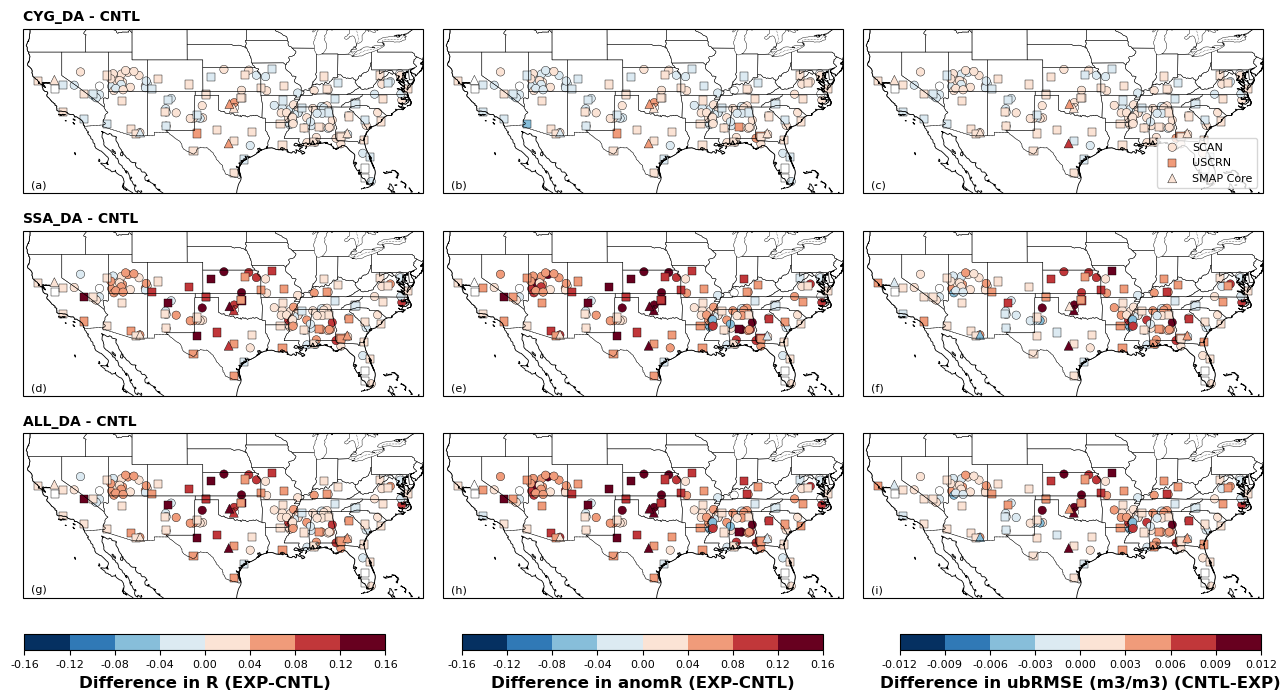

In [7]:
# Combined 3x3 overlay for all networks (SCAN, USCRN, SMAP Core) with SMAP on top
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
from matplotlib.cm import get_cmap

# Build overlay order using existing networks (use 6yr tags), SMAP drawn last
order_labels = ['SCAN', 'USCRN', 'SMAP Core']
markers = {'SCAN': ('o', 36), 'USCRN': ('s', 34), 'SMAP Core': ('^', 42)}
overlay_networks = []
for lbl in order_labels:
    for tag, nlabel in networks:
        if nlabel == lbl:
            marker, size = markers.get(lbl, ('o', 36))
            overlay_networks.append((tag, nlabel, marker, size))
            break

levels_R = np.linspace(-0.16, 0.16, 9)
levels_anomR = np.linspace(-0.16, 0.16, 9)
levels_ub = np.linspace(-0.012, 0.012, 9)
cmaps = [get_cmap('RdBu_r', len(levels_R)-1),
         get_cmap('RdBu_r', len(levels_anomR)-1),
         get_cmap('RdBu_r',   len(levels_ub)-1)]
levels_list = [levels_R, levels_anomR, levels_ub]
titles_col = ['Difference in R (EXP-CNTL)', 'Difference in anomR (EXP-CNTL)', 'Difference in ubRMSE (m3/m3) (CNTL-EXP)']
labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)']
rows = [
    ('CYG_DA - CNTL', 1),
    ('SSA_DA - CNTL', 2),
    ('ALL_DA - CNTL', 3),
]

# Determine control prefix
if 'experiment_names' in globals():
    control_prefix = experiment_names[0]
elif 'experiments' in globals():
    control_prefix = experiments[0]['prefix']
else:
    raise NameError('experiment_names/experiments not defined; run setup cells first')

# Precompute arrays and lat/lon per network
overlay_data = {}
for tag, nlabel, _, _ in overlay_networks:
    try:
        nidx = next(i for i, (t, _) in enumerate(networks) if t == tag)
    except StopIteration:
        raise ValueError(f'Network tag {tag} not found in networks={networks}')
    overlay_data[tag] = {
        'R': np.stack(store_R[nidx], axis=-1),
        'anomR': np.stack(store_anomR[nidx], axis=-1),
        'ubRMSE': np.stack(store_ub[nidx], axis=-1),
    }
    raw_path = BASE_DIR / f"{control_prefix}{tag}_raw_timeseries.mat"
    mat_raw = sio.loadmat(raw_path, squeeze_me=False)
    overlay_data[tag]['lat'] = mat_raw['INSITU_lat'].flatten()
    overlay_data[tag]['lon'] = mat_raw['INSITU_lon'].flatten()

fig, axes = plt.subplots(3, 3, figsize=(16, 8), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.reshape(3, 3)
lab_idx = 0
legend_handles = None
legend_labels = None
for r_idx, (row_title, exp_idx) in enumerate(rows):
    for c_idx, (metric, levels, cmap) in enumerate(zip(['R', 'anomR', 'ubRMSE'], levels_list, cmaps)):
        ax = axes[r_idx, c_idx]
        norm = BoundaryNorm(levels, cmap.N)
        for tag, nlabel, marker, size in overlay_networks:
            arr = overlay_data[tag][metric]
            if metric == 'ubRMSE':
                data = arr[:, 0, 0] - arr[:, 0, exp_idx]
            else:
                data = arr[:, 0, exp_idx] - arr[:, 0, 0]
            lat = overlay_data[tag]['lat']; lon = overlay_data[tag]['lon']
            sc = ax.scatter(lon, lat, c=data, cmap=cmap, norm=norm, s=size,
                            marker=marker, edgecolor='k', linewidths=0.3,
                            transform=ccrs.PlateCarree(), label=nlabel)
        ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
        ax.add_feature(cfeature.BORDERS, linewidth=0.4, linestyle=':')
        ax.add_feature(cfeature.STATES, linewidth=0.3)
        ax.set_extent([-125, -74, 24, 45], crs=ccrs.PlateCarree())
        ax.set_title(row_title if c_idx == 0 else '', fontsize=10, loc='left', fontweight='bold')
        ax.tick_params(labelbottom=False, labelleft=False)
        ax.text(0.02, 0.02, labels[lab_idx], transform=ax.transAxes,
                fontsize=8, va='bottom', ha='left')
        if legend_handles is None:
            legend_handles, legend_labels = ax.get_legend_handles_labels()
        lab_idx += 1

# Add a single legend
if legend_handles:
    axes[0,2].legend(legend_handles, legend_labels, loc='lower right', fontsize=8, frameon=True)

# Colorbars under each column
cbar_h = 0.02
bottom_row = axes[-1, :]
y_min = min(ax.get_position().y0 for ax in bottom_row)
gap = 0.02
cbar_y = y_min - gap - cbar_h
for levels, cmap, title, col_ax in zip(levels_list, cmaps, titles_col, axes.T):
    x0 = min(ax.get_position().x0 for ax in col_ax)
    x1 = max(ax.get_position().x1 for ax in col_ax)
    span = x1 - x0
    width = 0.99 * span
    xpos = x0 + 0.5 * (span - width)
    norm = BoundaryNorm(levels, cmap.N)
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    cax = fig.add_axes([xpos, cbar_y, width, cbar_h])
    cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
    cbar.set_label(title, fontsize=12, fontweight='bold')
    cbar.set_ticks(levels)
    if title.startswith('Difference in ubRMSE'):
        cbar.ax.set_xticklabels([f"{lvl:.3f}" for lvl in levels], fontsize=8)
    else:
        cbar.ax.set_xticklabels([f"{lvl:.2f}" for lvl in levels], fontsize=8)

plt.subplots_adjust(wspace=0.05, hspace=0.08, bottom=0.14)
# plt.suptitle('All networks overlay (SMAP Core on top)', fontsize=12, y=0.99)
plt.show()


In [8]:
import numpy as np
import os
from datetime import datetime
from dateutil.relativedelta import relativedelta
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import pickle

import sys
from pathlib import Path

def find_repo_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if (p / '.git').exists():
            return p
    return start

here = Path(__file__).resolve().parent if '__file__' in globals() else Path.cwd()
repo_root = find_repo_root(here)
sys.path.append(str(repo_root / 'common' / 'python' / 'io'))
sys.path.append(str(repo_root / 'projects' / 'matlab2python' / 'shared' / 'python'))
sys.path.append(str(repo_root / 'common' / 'python' / 'plotting'))
sys.path.append('../util/shared/python/')

EASE_PATH = repo_root / 'common' / 'python' / 'plotting' / 'ease_grids'

from read_GEOSldas import read_tilecoord, read_obs_param


# plotting removed (single-panel plot)


In [9]:
species_groups = {
    "CYGNSS": [11],
    "SMAP": [4, 5, 6, 7],
    "ASCAT": [8, 9, 10],
    "SMOS": [0, 1, 2, 3]
}

# species_groups = {
#     "CYGNSS": [11],
#     "SMAP": [4, 5],
#     "ASCAT": [8, 9, 10],
#     "SMOS": [0, 1]
# }

In [10]:
# Read in the OL data files

stats_file_OL = '/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/CYGNSS_Experiments/OLv8_M36_cd/' \
'OLv8_M36_cd/output/SMAP_EASEv2_M36_GLOBAL/figures/temporal_stats_OL_fixed_20180801_20240630.nc4'

print('reading stats nc4 file '+stats_file_OL)
stats_OL = {}
with Dataset(stats_file_OL,'r') as nc:
    for key, value in nc.variables.items():
        print(f"Reading variable: {key}")
        stats_OL[key] = value[:].filled(np.nan)

ts_stats_file_OL = '/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/CYGNSS_Experiments/OLv8_M36_cd/' \
'OLv8_M36_cd/output/SMAP_EASEv2_M36_GLOBAL/figures/spatial_stats_OL_fixed_201808_202406.pkl'

with open(ts_stats_file_OL, 'rb') as f:
    loaded_data = pickle.load(f)
stats_dict_OL = loaded_data
date_vec_OL = loaded_data.get('date_vec', None)  
date_vec = date_vec_OL 

reading stats nc4 file /Users/amfox/Desktop/GEOSldas_diagnostics/test_data/CYGNSS_Experiments/OLv8_M36_cd/OLv8_M36_cd/output/SMAP_EASEv2_M36_GLOBAL/figures/temporal_stats_OL_fixed_20180801_20240630.nc4
Reading variable: O_mean
Reading variable: O_stdv
Reading variable: F_mean
Reading variable: F_stdv
Reading variable: A_mean
Reading variable: A_stdv
Reading variable: OmF_mean
Reading variable: OmF_stdv
Reading variable: OmA_mean
Reading variable: OmA_stdv
Reading variable: OmF_norm_mean
Reading variable: OmF_norm_stdv
Reading variable: N_data


In [11]:
# Read in the DA data files
stats_file_DA = '/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/CYGNSS_Experiments/DAv8_M36_cd/' \
'DAv8_M36_cd/output/SMAP_EASEv2_M36_GLOBAL/figures/temporal_stats_DA_fixed_20180801_20240630.nc4'
print('reading stats nc4 file '+stats_file_DA)
stats_DA = {}
with Dataset(stats_file_DA,'r') as nc:
    for key, value in nc.variables.items():
        stats_DA[key] = value[:].filled(np.nan)

ts_stats_file_DA = '/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/CYGNSS_Experiments/DAv8_M36_cd/' \
'DAv8_M36_cd/output/SMAP_EASEv2_M36_GLOBAL/figures/spatial_stats_DA_fixed_201808_202406.pkl'

with open(ts_stats_file_DA, 'rb') as f:
    loaded_data = pickle.load(f)
stats_dict_DA = loaded_data
date_vec_DA = loaded_data.get('date_vec', None) 

reading stats nc4 file /Users/amfox/Desktop/GEOSldas_diagnostics/test_data/CYGNSS_Experiments/DAv8_M36_cd/DAv8_M36_cd/output/SMAP_EASEv2_M36_GLOBAL/figures/temporal_stats_DA_fixed_20180801_20240630.nc4


In [12]:
# Read in the DA data files
stats_file_DA_all = '/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/CYGNSS_Experiments/DAv8_M36_cd_all/' \
'DAv8_M36_cd_all/output/SMAP_EASEv2_M36_GLOBAL/figures/temporal_stats_DA_fixed_20180801_20240630.nc4'
print('reading stats nc4 file '+stats_file_DA_all)
stats_DA_all = {}
with Dataset(stats_file_DA_all,'r') as nc:
    for key, value in nc.variables.items():
        stats_DA_all[key] = value[:].filled(np.nan)

ts_stats_file_DA_all = '/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/CYGNSS_Experiments/DAv8_M36_cd_all/' \
'DAv8_M36_cd_all/output/SMAP_EASEv2_M36_GLOBAL/figures/spatial_stats_DA_fixed_201808_202406.pkl'

with open(ts_stats_file_DA_all, 'rb') as f:
    loaded_data = pickle.load(f)
stats_dict_DA_all = loaded_data
date_vec_DA_all = loaded_data.get('date_vec', None) 

reading stats nc4 file /Users/amfox/Desktop/GEOSldas_diagnostics/test_data/CYGNSS_Experiments/DAv8_M36_cd_all/DAv8_M36_cd_all/output/SMAP_EASEv2_M36_GLOBAL/figures/temporal_stats_DA_fixed_20180801_20240630.nc4


In [13]:
# Read in the DA data files
stats_file_DA_ssa = '/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/CYGNSS_Experiments/DAv8_M36_cd_ssa/' \
'DAv8_M36_cd_ssa/output/SMAP_EASEv2_M36_GLOBAL/figures/temporal_stats_DA_fixed_20180801_20240630.nc4'
print('reading stats nc4 file '+stats_file_DA_ssa)
stats_DA_ssa = {}
with Dataset(stats_file_DA_ssa,'r') as nc:
    for key, value in nc.variables.items():
        stats_DA_ssa[key] = value[:].filled(np.nan)

ts_stats_file_DA_ssa = '/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/CYGNSS_Experiments/DAv8_M36_cd_ssa/' \
'DAv8_M36_cd_ssa/output/SMAP_EASEv2_M36_GLOBAL/figures/spatial_stats_DA_fixed_201808_202406.pkl'

with open(ts_stats_file_DA_ssa, 'rb') as f:
    loaded_data = pickle.load(f)
stats_dict_DA_ssa = loaded_data
date_vec_DA_ssa = loaded_data.get('date_vec', None) 

reading stats nc4 file /Users/amfox/Desktop/GEOSldas_diagnostics/test_data/CYGNSS_Experiments/DAv8_M36_cd_ssa/DAv8_M36_cd_ssa/output/SMAP_EASEv2_M36_GLOBAL/figures/temporal_stats_DA_fixed_20180801_20240630.nc4


In [14]:
# Sample of final compuation of selected diagnostic metrics for OL
 
Nmin = 20

# Then computer metrics of O-F, O-A, etc. based on above computed
N_data = stats_OL['N_data']
O_mean = stats_OL['O_mean']
A_mean = stats_OL['A_mean']
F_mean = stats_OL['F_mean']
O_stdv = stats_OL['O_stdv']
A_stdv = stats_OL['A_stdv']
F_stdv = stats_OL['F_stdv']
OmF_mean = stats_OL['OmF_mean']
OmF_stdv = stats_OL['OmF_stdv']
OmF_norm_mean = stats_OL['OmF_norm_mean']
OmF_norm_stdv = stats_OL['OmF_norm_stdv']
OmA_mean = stats_OL['OmA_mean']
OmA_stdv = stats_OL['OmA_stdv']
  
# Mask out data points with insufficent observations using the Nmin threshold
# Do NOT apply to N_data
OmF_mean[     N_data < Nmin] = np.nan
OmF_stdv[     N_data < Nmin] = np.nan
OmF_norm_mean[N_data < Nmin] = np.nan
OmF_norm_stdv[N_data < Nmin] = np.nan
OmA_mean[     N_data < Nmin] = np.nan
OmA_stdv[     N_data < Nmin] = np.nan
N_data[       N_data < Nmin] = 0

OmF_mean_OL = OmF_mean
OmF_stdv_OL = OmF_stdv
OmF_norm_mean_OL = OmF_norm_mean
OmF_norm_stdv_OL = OmF_norm_stdv
OmA_mean_OL = OmA_mean
OmA_stdv_OL = OmA_stdv
N_data_OL = N_data

group_metrics_OL = {}

for group, species_indices in species_groups.items():
    group_metrics_OL[group] = {}
    group_N_data = np.nansum(N_data[:, species_indices], axis=1)
    
    group_metrics_OL[group]['OmF_mean'] = np.nansum(OmF_mean[:, species_indices] * N_data[:, species_indices], axis=1) / group_N_data
    group_metrics_OL[group]['OmF_stdv'] = np.nansum(OmF_stdv[:, species_indices] * N_data[:, species_indices], axis=1) / group_N_data
    group_metrics_OL[group]['OmF_norm_mean'] = np.nansum(OmF_norm_mean[:, species_indices] * N_data[:, species_indices], axis=1) / group_N_data
    group_metrics_OL[group]['OmF_norm_stdv'] = np.nansum(OmF_norm_stdv[:, species_indices] * N_data[:, species_indices], axis=1) / group_N_data
    group_metrics_OL[group]['OmA_mean'] = np.nansum(OmA_mean[:, species_indices] * N_data[:, species_indices], axis=1) / group_N_data
    group_metrics_OL[group]['OmA_stdv'] = np.nansum(OmA_stdv[:, species_indices] * N_data[:, species_indices], axis=1) / group_N_data
    group_metrics_OL[group]['Nobs_data'] = group_N_data


/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_50535/3977554994.py:44: RuntimeWarning: invalid value encountered in divide
  group_metrics_OL[group]['OmF_mean'] = np.nansum(OmF_mean[:, species_indices] * N_data[:, species_indices], axis=1) / group_N_data
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_50535/3977554994.py:45: RuntimeWarning: invalid value encountered in divide
  group_metrics_OL[group]['OmF_stdv'] = np.nansum(OmF_stdv[:, species_indices] * N_data[:, species_indices], axis=1) / group_N_data
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_50535/3977554994.py:46: RuntimeWarning: invalid value encountered in divide
  group_metrics_OL[group]['OmF_norm_mean'] = np.nansum(OmF_norm_mean[:, species_indices] * N_data[:, species_indices], axis=1) / group_N_data
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_50535/3977554994.py:47: RuntimeWarning: invalid value encountered in divide
  group_metrics_OL[group]['OmF_norm_stdv'] = np.nansum

In [15]:

# Sample of final compuation of selected diagnostic metrics for DA

# Then computer metrics of O-F, O-A, etc. based on above computed
N_data = stats_DA['N_data']
O_mean = stats_DA['O_mean']
A_mean = stats_DA['A_mean']
F_mean = stats_DA['F_mean']
O_stdv = stats_DA['O_stdv']
A_stdv = stats_DA['A_stdv']
F_stdv = stats_DA['F_stdv']
OmF_mean = stats_DA['OmF_mean']
OmF_stdv = stats_DA['OmF_stdv']
OmF_norm_mean = stats_DA['OmF_norm_mean']
OmF_norm_stdv = stats_DA['OmF_norm_stdv']
OmA_mean = stats_DA['OmA_mean']
OmA_stdv = stats_DA['OmA_stdv']

# Mask out data points with insufficent observations using the Nmin threshold
# Do NOT apply to N_data
OmF_mean[     N_data < Nmin] = np.nan
OmF_stdv[     N_data < Nmin] = np.nan
OmF_norm_mean[N_data < Nmin] = np.nan
OmF_norm_stdv[N_data < Nmin] = np.nan
OmA_mean[     N_data < Nmin] = np.nan
OmA_stdv[     N_data < Nmin] = np.nan
N_data[       N_data < Nmin] = 0
OmF_mean_DA = OmF_mean
OmF_stdv_DA = OmF_stdv
OmF_norm_mean_DA = OmF_norm_mean
OmF_norm_stdv_DA = OmF_norm_stdv
OmA_mean_DA = OmA_mean
OmA_stdv_DA = OmA_stdv
N_data_DA = N_data

group_metrics_DA = {}

for group, species_indices in species_groups.items():
    group_metrics_DA[group] = {}
    group_N_data = np.nansum(N_data[:, species_indices], axis=1)
    
    group_metrics_DA[group]['OmF_mean'] = np.nansum(OmF_mean[:, species_indices] * N_data[:, species_indices], axis=1) / group_N_data
    group_metrics_DA[group]['OmF_stdv'] = np.nansum(OmF_stdv[:, species_indices] * N_data[:, species_indices], axis=1) / group_N_data
    group_metrics_DA[group]['OmF_norm_mean'] = np.nansum(OmF_norm_mean[:, species_indices] * N_data[:, species_indices], axis=1) / group_N_data
    group_metrics_DA[group]['OmF_norm_stdv'] = np.nansum(OmF_norm_stdv[:, species_indices] * N_data[:, species_indices], axis=1) / group_N_data
    group_metrics_DA[group]['OmA_mean'] = np.nansum(OmA_mean[:, species_indices] * N_data[:, species_indices], axis=1) / group_N_data
    group_metrics_DA[group]['OmA_stdv'] = np.nansum(OmA_stdv[:, species_indices] * N_data[:, species_indices], axis=1) / group_N_data
    group_metrics_DA[group]['Nobs_data'] = group_N_data


/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_50535/4095136516.py:41: RuntimeWarning: invalid value encountered in divide
  group_metrics_DA[group]['OmF_mean'] = np.nansum(OmF_mean[:, species_indices] * N_data[:, species_indices], axis=1) / group_N_data
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_50535/4095136516.py:42: RuntimeWarning: invalid value encountered in divide
  group_metrics_DA[group]['OmF_stdv'] = np.nansum(OmF_stdv[:, species_indices] * N_data[:, species_indices], axis=1) / group_N_data
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_50535/4095136516.py:43: RuntimeWarning: invalid value encountered in divide
  group_metrics_DA[group]['OmF_norm_mean'] = np.nansum(OmF_norm_mean[:, species_indices] * N_data[:, species_indices], axis=1) / group_N_data
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_50535/4095136516.py:44: RuntimeWarning: invalid value encountered in divide
  group_metrics_DA[group]['OmF_norm_stdv'] = np.nansum

In [16]:
# Then computer metrics of O-F, O-A, etc. based on above computed
N_data = stats_DA_all['N_data']
O_mean = stats_DA_all['O_mean']
A_mean = stats_DA_all['A_mean']
F_mean = stats_DA_all['F_mean']
O_stdv = stats_DA_all['O_stdv']
A_stdv = stats_DA_all['A_stdv']
F_stdv = stats_DA_all['F_stdv']
OmF_mean = stats_DA_all['OmF_mean']
OmF_stdv = stats_DA_all['OmF_stdv']
OmF_norm_mean = stats_DA_all['OmF_norm_mean']
OmF_norm_stdv = stats_DA_all['OmF_norm_stdv']
OmA_mean = stats_DA_all['OmA_mean']
OmA_stdv = stats_DA_all['OmA_stdv']

# Mask out data points with insufficent observations using the Nmin threshold
# Do NOT apply to N_data
OmF_mean[     N_data < Nmin] = np.nan
OmF_stdv[     N_data < Nmin] = np.nan
OmF_norm_mean[N_data < Nmin] = np.nan
OmF_norm_stdv[N_data < Nmin] = np.nan
OmA_mean[     N_data < Nmin] = np.nan
OmA_stdv[     N_data < Nmin] = np.nan
N_data[       N_data < Nmin] = 0
OmF_mean_DA_all = OmF_mean
OmF_stdv_DA_all = OmF_stdv
OmF_norm_mean_DA_all = OmF_norm_mean
OmF_norm_stdv_DA_all = OmF_norm_stdv
OmA_mean_DA_all = OmA_mean
OmA_stdv_DA_all = OmA_stdv
N_data_DA_all = N_data

group_metrics_DA_all = {}

for group, species_indices in species_groups.items():
    group_metrics_DA_all[group] = {}
    group_N_data = np.nansum(N_data[:, species_indices], axis=1)
    
    group_metrics_DA_all[group]['OmF_mean'] = np.nansum(OmF_mean[:, species_indices] * N_data[:, species_indices], axis=1) / group_N_data
    group_metrics_DA_all[group]['OmF_stdv'] = np.nansum(OmF_stdv[:, species_indices] * N_data[:, species_indices], axis=1) / group_N_data
    group_metrics_DA_all[group]['OmF_norm_mean'] = np.nansum(OmF_norm_mean[:, species_indices] * N_data[:, species_indices], axis=1) / group_N_data
    group_metrics_DA_all[group]['OmF_norm_stdv'] = np.nansum(OmF_norm_stdv[:, species_indices] * N_data[:, species_indices], axis=1) / group_N_data
    group_metrics_DA_all[group]['OmA_mean'] = np.nansum(OmA_mean[:, species_indices] * N_data[:, species_indices], axis=1) / group_N_data
    group_metrics_DA_all[group]['OmA_stdv'] = np.nansum(OmA_stdv[:, species_indices] * N_data[:, species_indices], axis=1) / group_N_data
    group_metrics_DA_all[group]['Nobs_data'] = group_N_data

/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_50535/452541659.py:39: RuntimeWarning: invalid value encountered in divide
  group_metrics_DA_all[group]['OmF_mean'] = np.nansum(OmF_mean[:, species_indices] * N_data[:, species_indices], axis=1) / group_N_data
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_50535/452541659.py:40: RuntimeWarning: invalid value encountered in divide
  group_metrics_DA_all[group]['OmF_stdv'] = np.nansum(OmF_stdv[:, species_indices] * N_data[:, species_indices], axis=1) / group_N_data
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_50535/452541659.py:41: RuntimeWarning: invalid value encountered in divide
  group_metrics_DA_all[group]['OmF_norm_mean'] = np.nansum(OmF_norm_mean[:, species_indices] * N_data[:, species_indices], axis=1) / group_N_data
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_50535/452541659.py:42: RuntimeWarning: invalid value encountered in divide
  group_metrics_DA_all[group]['OmF_norm_stdv']

In [17]:
# Then computer metrics of O-F, O-A, etc. based on above computed
N_data = stats_DA_ssa['N_data']
O_mean = stats_DA_ssa['O_mean']
A_mean = stats_DA_ssa['A_mean']
F_mean = stats_DA_ssa['F_mean']
O_stdv = stats_DA_ssa['O_stdv']
A_stdv = stats_DA_ssa['A_stdv']
F_stdv = stats_DA_ssa['F_stdv']
OmF_mean = stats_DA_ssa['OmF_mean']
OmF_stdv = stats_DA_ssa['OmF_stdv']
OmF_norm_mean = stats_DA_ssa['OmF_norm_mean']
OmF_norm_stdv = stats_DA_ssa['OmF_norm_stdv']
OmA_mean = stats_DA_ssa['OmA_mean']
OmA_stdv = stats_DA_ssa['OmA_stdv']

# Mask out data points with insufficent observations using the Nmin threshold
# Do NOT apply to N_data
OmF_mean[     N_data < Nmin] = np.nan
OmF_stdv[     N_data < Nmin] = np.nan
OmF_norm_mean[N_data < Nmin] = np.nan
OmF_norm_stdv[N_data < Nmin] = np.nan
OmA_mean[     N_data < Nmin] = np.nan
OmA_stdv[     N_data < Nmin] = np.nan
N_data[       N_data < Nmin] = 0
OmF_mean_DA_ssa = OmF_mean
OmF_stdv_DA_ssa = OmF_stdv
OmF_norm_mean_DA_ssa = OmF_norm_mean
OmF_norm_stdv_DA_ssa = OmF_norm_stdv
OmA_mean_DA_ssa = OmA_mean
OmA_stdv_DA_ssa = OmA_stdv
N_data_DA_ssa = N_data

group_metrics_DA_ssa = {}

for group, species_indices in species_groups.items():
    group_metrics_DA_ssa[group] = {}
    group_N_data = np.nansum(N_data[:, species_indices], axis=1)
    
    group_metrics_DA_ssa[group]['OmF_mean'] = np.nansum(OmF_mean[:, species_indices] * N_data[:, species_indices], axis=1) / group_N_data
    group_metrics_DA_ssa[group]['OmF_stdv'] = np.nansum(OmF_stdv[:, species_indices] * N_data[:, species_indices], axis=1) / group_N_data
    group_metrics_DA_ssa[group]['OmF_norm_mean'] = np.nansum(OmF_norm_mean[:, species_indices] * N_data[:, species_indices], axis=1) / group_N_data
    group_metrics_DA_ssa[group]['OmF_norm_stdv'] = np.nansum(OmF_norm_stdv[:, species_indices] * N_data[:, species_indices], axis=1) / group_N_data
    group_metrics_DA_ssa[group]['OmA_mean'] = np.nansum(OmA_mean[:, species_indices] * N_data[:, species_indices], axis=1) / group_N_data
    group_metrics_DA_ssa[group]['OmA_stdv'] = np.nansum(OmA_stdv[:, species_indices] * N_data[:, species_indices], axis=1) / group_N_data
    group_metrics_DA_ssa[group]['Nobs_data'] = group_N_data

/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_50535/1084405669.py:39: RuntimeWarning: invalid value encountered in divide
  group_metrics_DA_ssa[group]['OmF_mean'] = np.nansum(OmF_mean[:, species_indices] * N_data[:, species_indices], axis=1) / group_N_data
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_50535/1084405669.py:40: RuntimeWarning: invalid value encountered in divide
  group_metrics_DA_ssa[group]['OmF_stdv'] = np.nansum(OmF_stdv[:, species_indices] * N_data[:, species_indices], axis=1) / group_N_data
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_50535/1084405669.py:41: RuntimeWarning: invalid value encountered in divide
  group_metrics_DA_ssa[group]['OmF_norm_mean'] = np.nansum(OmF_norm_mean[:, species_indices] * N_data[:, species_indices], axis=1) / group_N_data
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_50535/1084405669.py:42: RuntimeWarning: invalid value encountered in divide
  group_metrics_DA_ssa[group]['OmF_norm_st

In [18]:
ftc = '/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/CYGNSS_Experiments/DAv8_M36_cd/' \
      'DAv8_M36_cd/output/SMAP_EASEv2_M36_GLOBAL/rc_out/DAv8_M36_cd.ldas_tilecoord.bin'
tc = read_tilecoord(ftc)
n_tile = tc['N_tile']
lat = tc['com_lat']
lon = tc['com_lon']

map_array = np.empty([n_tile, 3])
map_array.fill(np.nan)
map_array[:, 1] = lon
map_array[:, 2] = lat

reading from /Users/amfox/Desktop/GEOSldas_diagnostics/test_data/CYGNSS_Experiments/DAv8_M36_cd/DAv8_M36_cd/output/SMAP_EASEv2_M36_GLOBAL/rc_out/DAv8_M36_cd.ldas_tilecoord.bin
done reading file


In [19]:
def convert_stats_dict_to_arrays(stats_dict):
    """Convert dictionary of lists to numpy arrays"""
    array_dict = {}
    
    for key in stats_dict.keys():
        # Convert list to array and reshape
        array_dict[key] = np.array(stats_dict[key])
        
        # Check if we need to handle missing values (-- in data)
        if isinstance(array_dict[key][0], (list, np.ndarray)):
            # Replace '--' with np.nan
            temp_array = []
            for row in array_dict[key]:
                cleaned_row = [np.nan if x == '--' else float(x) for x in row]
                temp_array.append(cleaned_row)
            array_dict[key] = np.array(temp_array)
    
    return array_dict

# Convert dictionary
stats_dict_DA_arrays = convert_stats_dict_to_arrays(stats_dict_DA)
stats_dict_OL_arrays = convert_stats_dict_to_arrays(stats_dict_OL)
stats_dict_DA_all_arrays = convert_stats_dict_to_arrays(stats_dict_DA_all)
stats_DA_ssa_arrays = convert_stats_dict_to_arrays(stats_dict_DA_ssa)

# Convert date vector to datetime objects
date_vec_DA = [datetime.strptime(date, '%Y%m') for date in date_vec_DA]
date_vec_OL = [datetime.strptime(date, '%Y%m') for date in date_vec_OL]
date_vec_DA_all = [datetime.strptime(date, '%Y%m') for date in date_vec_DA_all]
date_vec_DA_ssa = [datetime.strptime(date, '%Y%m') for date in date_vec_DA_ssa]

# Print first few dates to verify
print("Sample dates:", date_vec_DA[:3])
# Print the last few dates to verify
print("Sample dates:", date_vec_DA[-3:])

Sample dates: [datetime.datetime(2018, 8, 1, 0, 0), datetime.datetime(2018, 9, 1, 0, 0), datetime.datetime(2018, 10, 1, 0, 0)]
Sample dates: [datetime.datetime(2024, 4, 1, 0, 0), datetime.datetime(2024, 5, 1, 0, 0), datetime.datetime(2024, 6, 1, 0, 0)]


In [20]:
def calculate_weighted_group_stats(stats_dict, species_groups):
    """Calculate weighted statistics for each group"""
    
    n_times = len(stats_dict['OmF_mean'])
    stats = ['O_mean','F_mean','OmF_mean', 'OmF_stdv', 'OmA_mean', 'OmA_stdv']
    
    # Initialize output dictionary
    group_stats = {}
    for group in species_groups.keys():
        group_stats[group] = {stat: np.zeros(n_times) for stat in stats}
        group_stats[group]['N_data'] = np.zeros(n_times)
    
    # Calculate weighted stats for each timestep
    for t in range(n_times):
        for group, indices in species_groups.items():
            # Get weights for this group/time
            weights = stats_dict['N_data'][t, indices]
            total_weight = np.sum(weights)
            
            if total_weight > 0:
                # Calculate weighted statistics
                for stat in stats:
                    values = stats_dict[stat][t, indices]
                    group_stats[group][stat][t] = np.average(values, weights=weights)
                group_stats[group]['N_data'][t] = total_weight
            else:
                # Set to NaN if no observations
                for stat in stats:
                    group_stats[group][stat][t] = np.nan
                    
    return group_stats

# Calculate group means
group_ts_DA = calculate_weighted_group_stats(stats_dict_DA_arrays, species_groups)
group_ts_OL = calculate_weighted_group_stats(stats_dict_OL_arrays, species_groups)
group_ts_DA_all = calculate_weighted_group_stats(stats_dict_DA_all_arrays, species_groups)
group_ts_DA_ssa = calculate_weighted_group_stats(stats_DA_ssa_arrays, species_groups)

In [21]:
print("length of date_vec_DA", len(date_vec_DA))
print("length of date_vec", len(date_vec))
print("length of date_vec_DA_all", len(date_vec_DA_all))
print("length of date_vec_DA_ssa", len(date_vec_DA_ssa))

length of date_vec_DA 71
length of date_vec 71
length of date_vec_DA_all 71
length of date_vec_DA_ssa 71


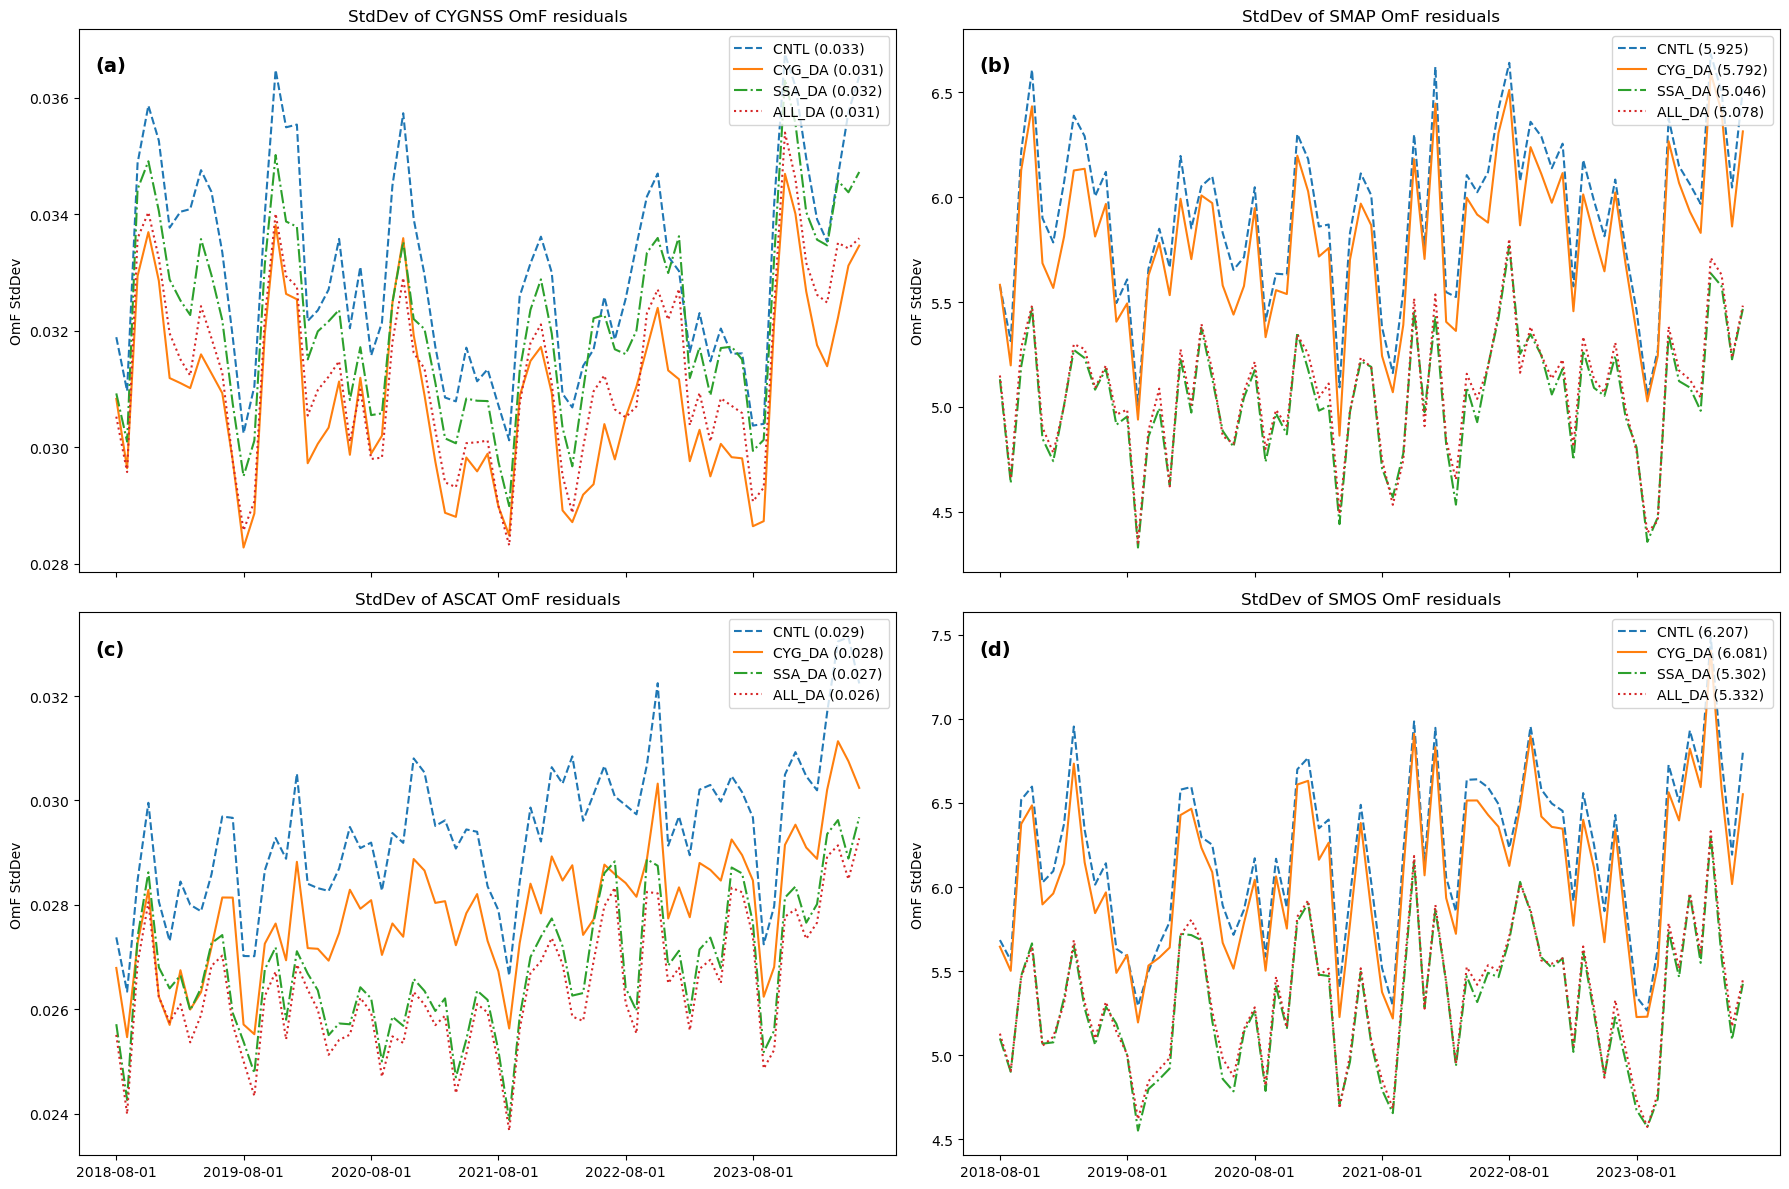

In [22]:
# 2x2 panel: OM-F stddev time series per species
# Panel order: CYGNSS (a), SMAP (b), ASCAT (c), SMOS (d)
panel_order = ["CYGNSS", "SMAP", "ASCAT", "SMOS"]
panel_labels = ["(a)", "(b)", "(c)", "(d)"]
fig, axes = plt.subplots(2, 2, figsize=(18, 12), sharex=True)
axes = axes.flatten()

for ax, species, lab in zip(axes, panel_order, panel_labels):
    mean_OL = np.nanmean(group_ts_OL[species]['OmF_stdv'])
    mean_DA = np.nanmean(group_ts_DA[species]['OmF_stdv'])
    mean_DA_all = np.nanmean(group_ts_DA_all[species]['OmF_stdv'])
    mean_DA_ssa = np.nanmean(group_ts_DA_ssa[species]['OmF_stdv'])

    ax.plot(date_vec_DA, group_ts_OL[species]['OmF_stdv'], '--', label=f'CNTL ({mean_OL:.3f})')
    ax.plot(date_vec_DA, group_ts_DA[species]['OmF_stdv'], '-', label=f'CYG_DA ({mean_DA:.3f})')
    ax.plot(date_vec_DA_ssa, group_ts_DA_ssa[species]['OmF_stdv'], '-.', label=f'SSA_DA ({mean_DA_ssa:.3f})')
    ax.plot(date_vec_DA_all, group_ts_DA_all[species]['OmF_stdv'], ':', label=f'ALL_DA ({mean_DA_all:.3f})')

    ax.set_title(f'StdDev of {species} OmF residuals')
    ax.set_ylabel('OmF StdDev')
    ax.text(0.02, 0.95, lab, transform=ax.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
    ax.legend(loc='upper right', fontsize=10)

# Only bottom panels get x labels/ticks
for i, ax in enumerate(axes):
    if i in [2, 3]:
        # ax.set_xlabel('Date')
        ax.set_xticks(date_vec_DA[::12])
        ax.tick_params(axis='x')
    else:
        ax.tick_params(axis='x', labelbottom=False)

plt.tight_layout()
plt.show()


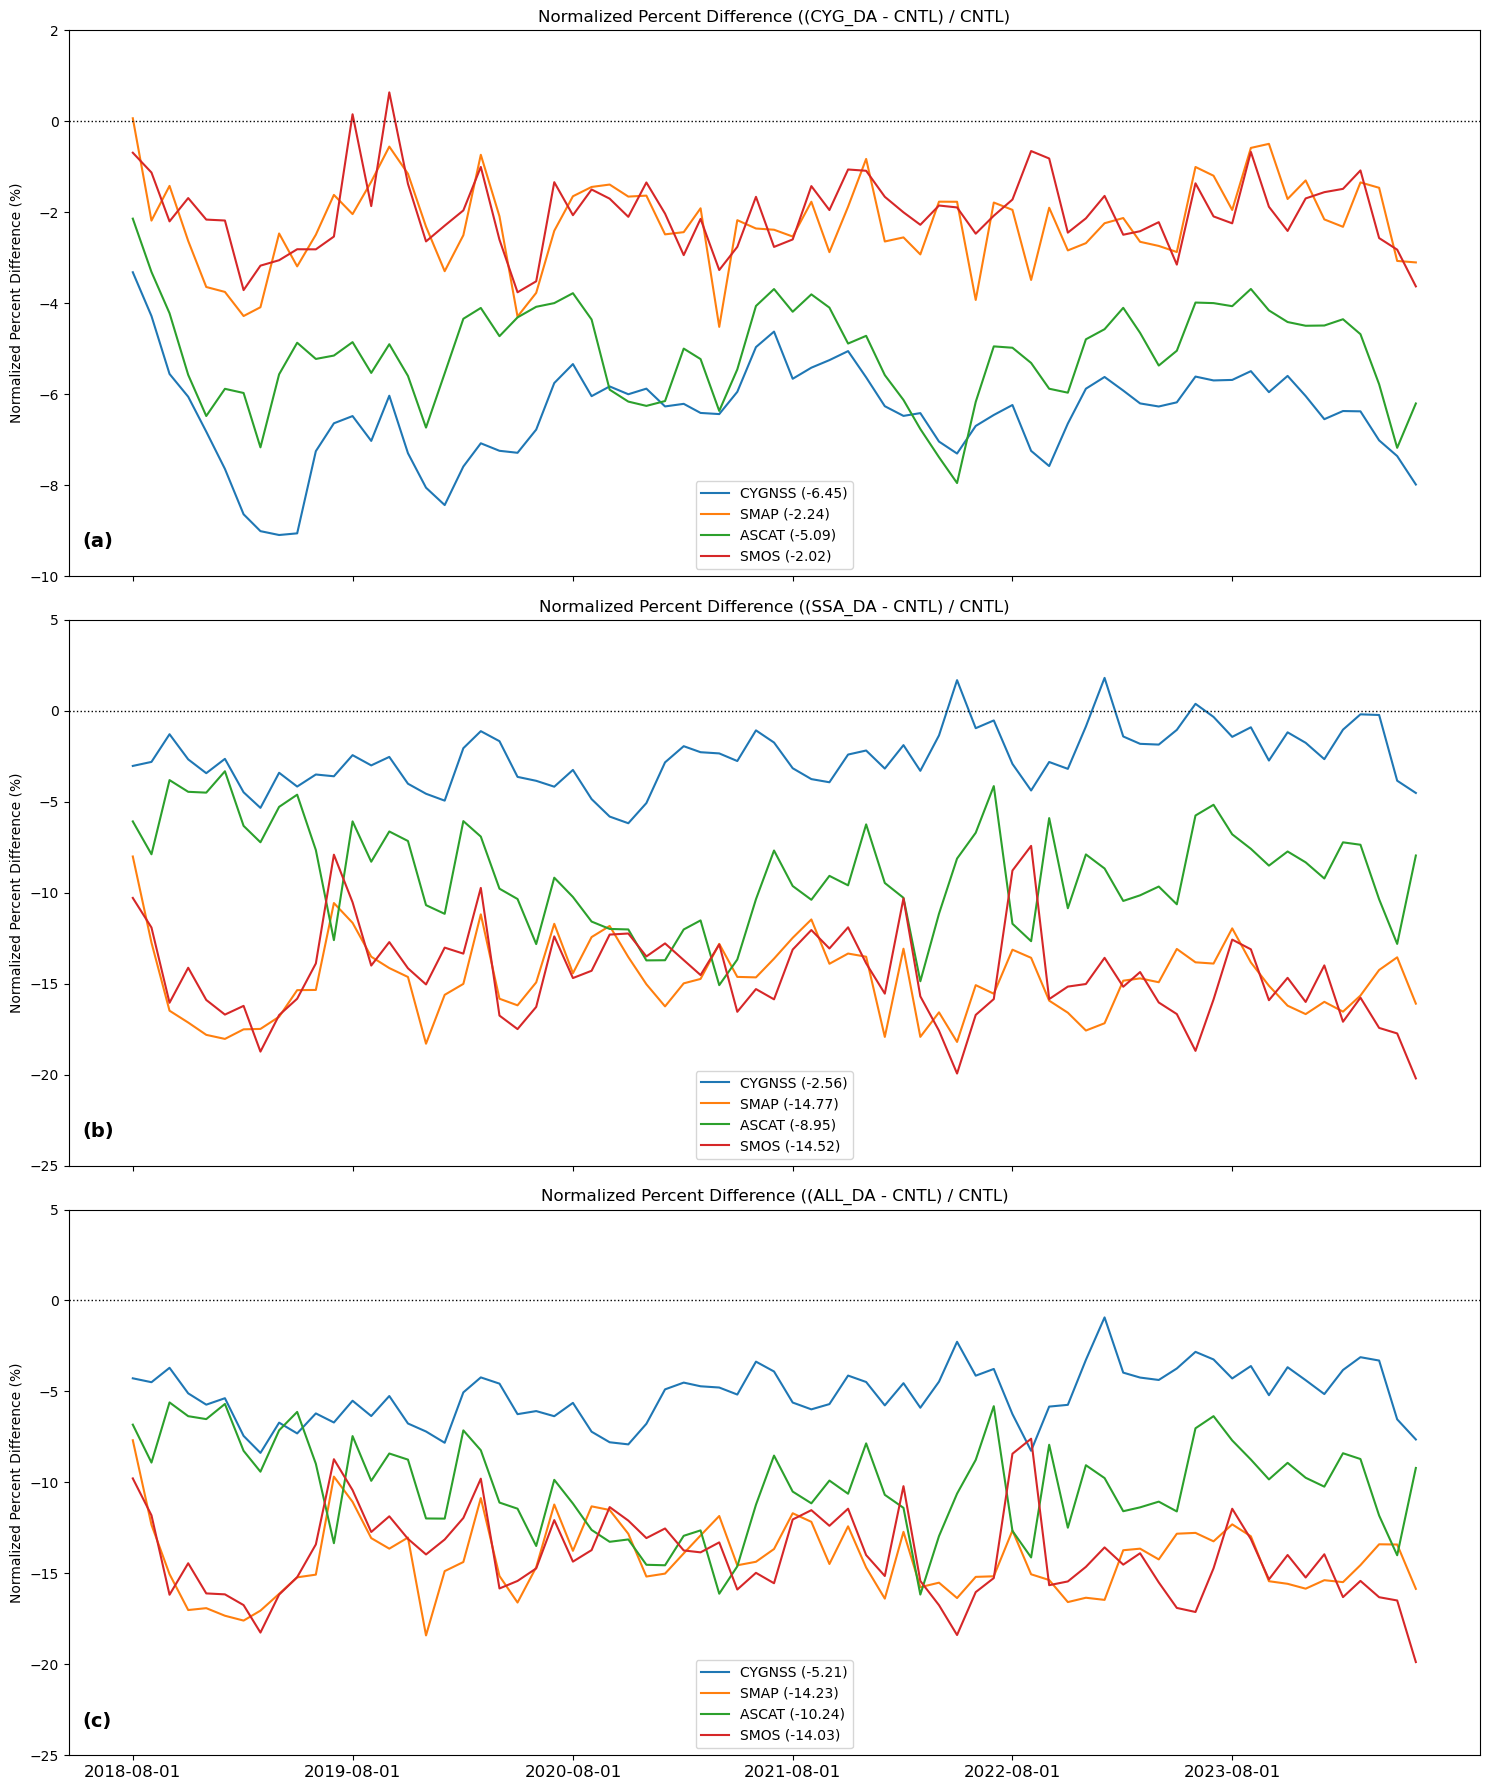

In [23]:
# Combined normalized percent difference for CYG_DA, SSA_DA, ALL_DA
fig, axes = plt.subplots(3, 1, figsize=(15, 18), sharex=True)
labels = ["(a)", "(b)", "(c)"]
panels = [
    (group_ts_DA, date_vec_DA, "Normalized Percent Difference ((CYG_DA - CNTL) / CNTL)", (-10, 2)),
    (group_ts_DA_ssa, date_vec_DA_ssa, "Normalized Percent Difference ((SSA_DA - CNTL) / CNTL)", (-25, 5)),
    (group_ts_DA_all, date_vec_DA, "Normalized Percent Difference ((ALL_DA - CNTL) / CNTL)", (-25, 5)),
]
groups_to_plot = list(species_groups.keys())[:4]

for i, (ax, (ts_dict, dates, title, ylim), lab) in enumerate(zip(axes, panels, labels)):
    for group in groups_to_plot:
        norm_percent_diff = np.divide(
            (ts_dict[group]['OmF_stdv'] - group_ts_OL[group]['OmF_stdv']),
            group_ts_OL[group]['OmF_stdv'],
            out=np.full_like(group_ts_OL[group]['OmF_stdv'], np.nan, dtype=float),
            where=group_ts_OL[group]['OmF_stdv'] != 0
        ) * 100
        mean_diff = np.nanmean(norm_percent_diff)
        ax.plot(dates, norm_percent_diff, label=f'{group} ({mean_diff:.2f})')
    
    ax.set_title(title)
    ax.set_ylabel('Normalized Percent Difference (%)')
    ax.axhline(y=0, color='black', linestyle=':', linewidth=1)
    ax.set_ylim(*ylim)
    ax.text(0.01, 0.08, lab, transform=ax.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
    ax.legend()  # Add legend to each subplot
    
    # Only show x-axis labels and ticks on the bottom plot
    if i < 2:  # Top two plots
        ax.tick_params(axis='x', labelbottom=False)
    else:  # Bottom plot
        # ax.set_xlabel('Date')
        ax.set_xticks(dates[::12])
        ax.set_xticklabels([d.strftime('%Y-%m-%d') for d in dates[::12]], fontsize=12)
        ax.tick_params(axis='x')

plt.tight_layout()
plt.show()


/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_50535/566293668.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis', len(edges)-1)
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_50535/566293668.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis', len(edges)-1)
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_50535/566293668.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  

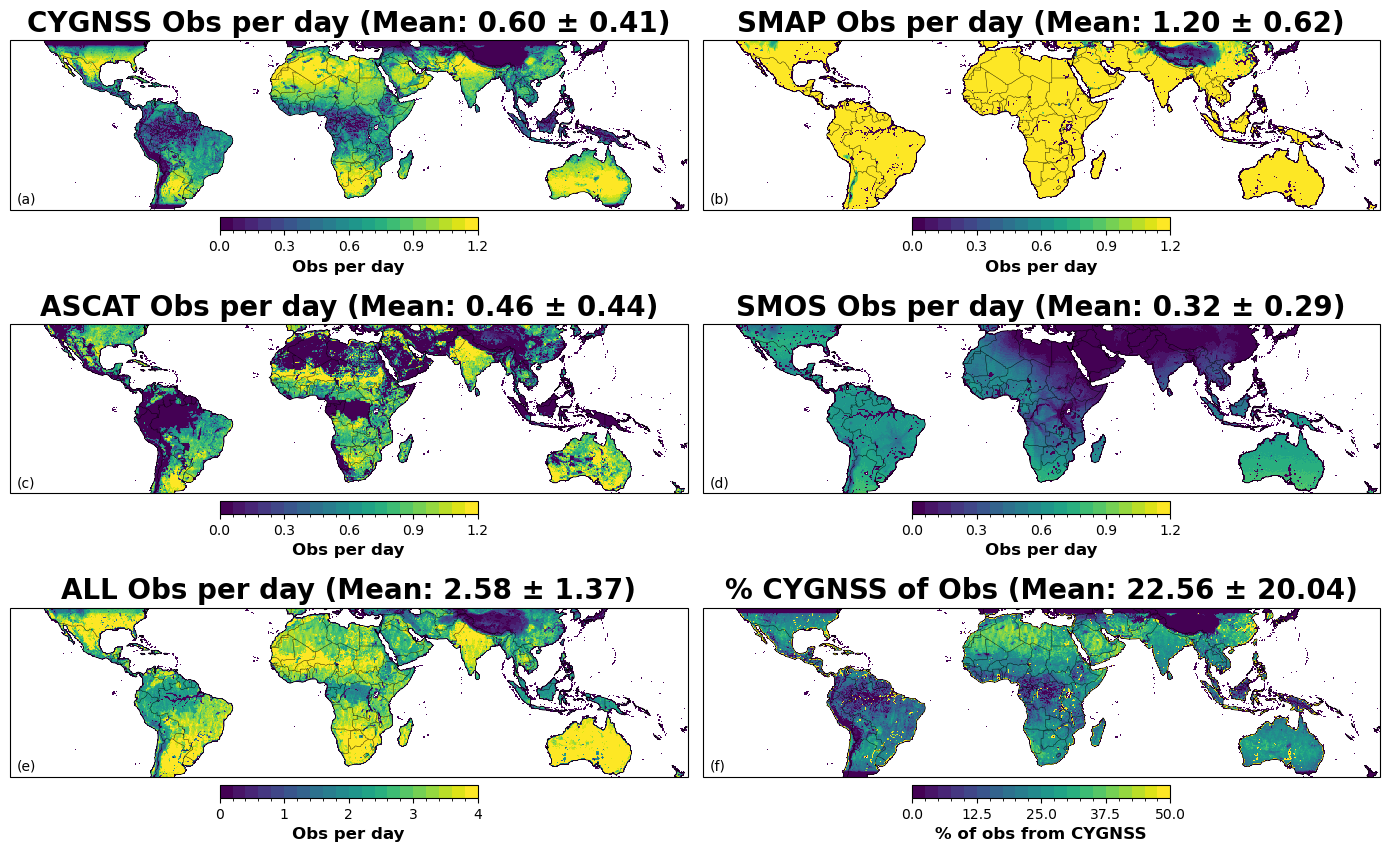

In [24]:
# 6-panel map: CYGNSS, SMAP, ASCAT, SMOS, ALL, %CYGNSS (Obs/day)
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from common.python.plotting.geospatial_plotting import load_ease_grid, build_ease_grid_mapping
from matplotlib.colors import BoundaryNorm
from matplotlib.cm import get_cmap

ndays = 2161
# Initialize map_array with proper shape (n_tile, 3) where columns are: data, lon, lat
map_array = np.empty([n_tile, 3])
map_array.fill(np.nan)
map_array[:, 1] = lon
map_array[:, 2] = lat

def compute_per_day(group_metrics, group_name):
    raw = group_metrics[group_name]['Nobs_data']
    return np.nan_to_num(raw / ndays, nan=0.0, posinf=0.0, neginf=0.0)

# Per-day counts per group
per_day_maps = {g: compute_per_day(group_metrics_DA, g) for g in species_groups.keys()}
# Totals and cygnss fraction
total_obs_per_day = sum(per_day_maps.values())
cygnss_obs_per_day = per_day_maps.get('CYGNSS', np.zeros_like(total_obs_per_day))
frac_cygnss = np.divide(cygnss_obs_per_day, total_obs_per_day, out=np.zeros_like(total_obs_per_day), where=total_obs_per_day>0)
percent_cygnss = 100.0 * frac_cygnss

# Helper to plot on given ax
lats, lons = load_ease_grid()
lats_row, lons_col = lats[:,1], lons[1,:]
lon_grid, lat_grid = np.meshgrid(lons_col, lats_row)

panel_defs = [
    ('CYGNSS', per_day_maps['CYGNSS'], 'CYGNSS Obs per day', (0, 1.2), '(a)'),
    ('SMAP',   per_day_maps['SMAP'],   'SMAP Obs per day',   (0, 1.2), '(b)'),
    ('ASCAT',  per_day_maps['ASCAT'],  'ASCAT Obs per day',  (0, 1.2), '(c)'),
    ('SMOS',   per_day_maps['SMOS'],   'SMOS Obs per day',   (0, 1.2), '(d)'),
    ('ALL',    total_obs_per_day,      'ALL Obs per day', (0, 4.0), '(e)'),
    ('%CYGNSS',percent_cygnss,         '% CYGNSS of Obs', (0, 50.0), '(f)'),
]

fig, axes = plt.subplots(3, 2, figsize=(14, 9), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()
for ax, (name, data_1d, title, clim, lab) in zip(axes, panel_defs):
    map_array[:,0] = data_1d
    grid = build_ease_grid_mapping(map_array, lats_row, lons_col)
    
    # Create custom colormap with 20 discrete colors
    edges = np.linspace(clim[0], clim[1], 21)  # 21 edges for 20 intervals
    cmap = get_cmap('viridis', len(edges)-1)
    norm = BoundaryNorm(edges, cmap.N)
    
    sc = ax.pcolormesh(lon_grid, lat_grid, grid, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    ax.set_extent(REGION_BOUNDS['cygnss'], crs=ccrs.PlateCarree())
    
    maxval = np.nanmax(data_1d)
    minval = np.nanmin(data_1d)
    meanval = np.nanmean(data_1d)
    stdval = np.nanstd(data_1d)
    ax.set_title(f"{title} (Mean: {meanval:.2f} ± {stdval:.2f})", fontsize=20, fontweight='bold')
    ax.text(0.01, 0.02, lab, transform=ax.transAxes, fontsize=10, va='bottom', ha='left')
    
    cbar = plt.colorbar(sc, ax=ax, orientation='horizontal', pad=0.03, fraction=0.05)
    units = 'Obs per day' if name != '%CYGNSS' else '% of obs from CYGNSS'
    cbar.set_label(units, fontsize=12, fontweight='bold')
    
    # Set 5 tick labels evenly spaced across the range
    tick_positions = np.linspace(clim[0], clim[1], 5)
    cbar.set_ticks(tick_positions)
    cbar.ax.tick_params(labelsize=10)
plt.tight_layout()
plt.show()


/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_50535/3445251792.py:83: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("RdBu_r", len(edges)-1)
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_50535/3445251792.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=(0, 0.08, 1, 1))


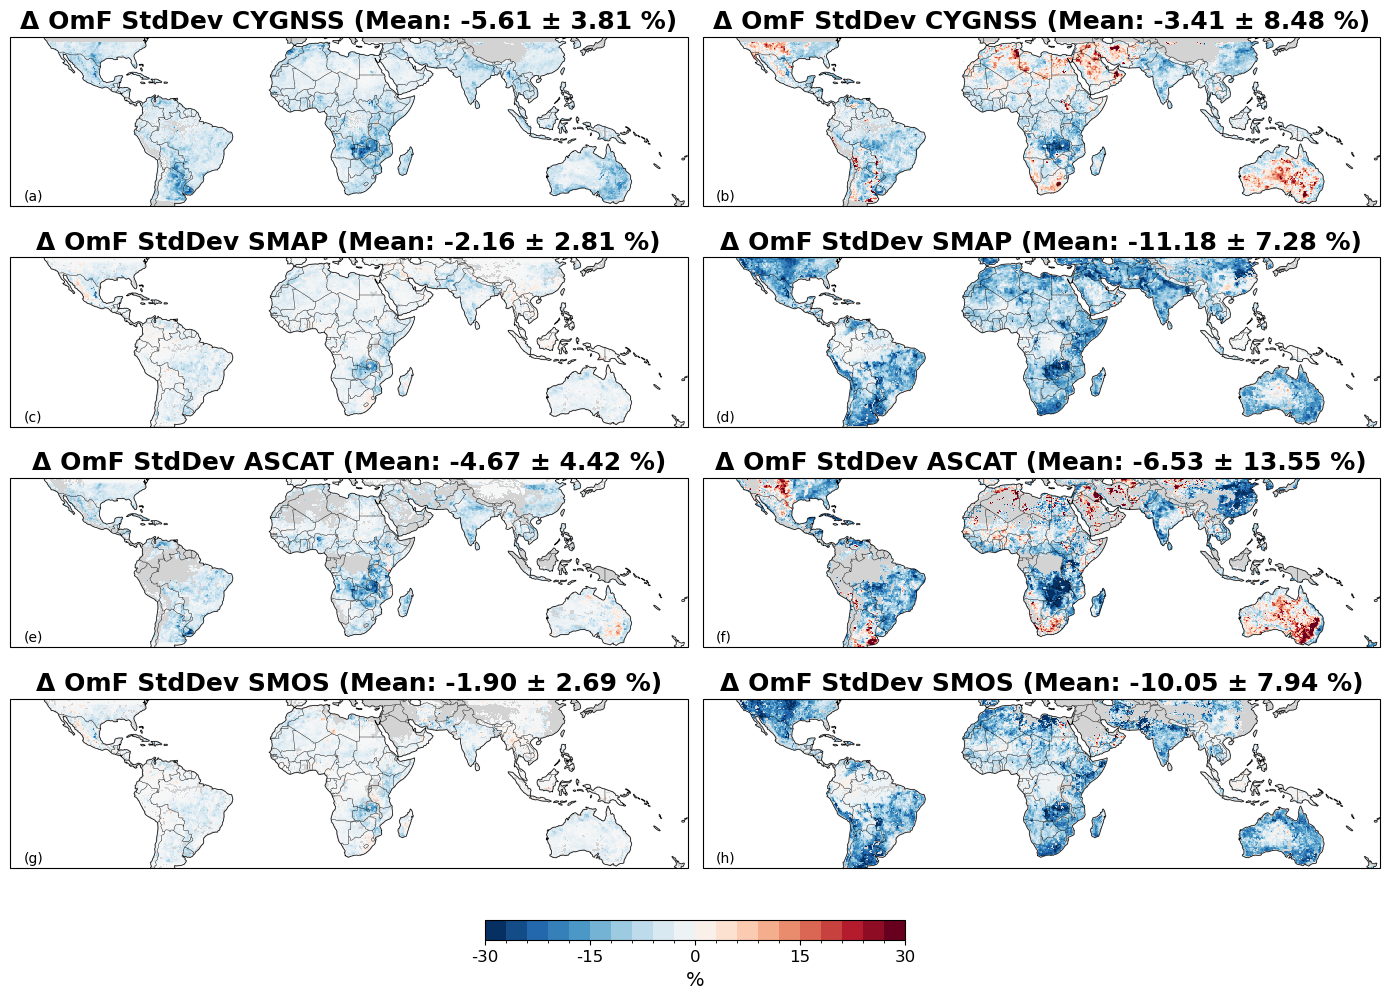

In [25]:
# 8-panel percent-difference maps (DA - CNTL) / CNTL for OmF StdDev
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from common.python.plotting.geospatial_plotting import load_ease_grid, build_ease_grid_mapping

# Helper to compute percent diff safely
def pct_diff(da, ol):
    return np.divide(da - ol, ol, out=np.full_like(ol, np.nan, dtype=float), where=ol != 0) * 100.0

# Prepare per-group percent differences
map_array = np.empty([n_tile, 3])
map_array.fill(np.nan)
map_array[:, 1] = lon
map_array[:, 2] = lat
map_array = map_array.copy()

pct_maps = {
    ('CYGNSS', 'CYG_DA'): pct_diff(group_metrics_DA['CYGNSS']['OmF_stdv'], group_metrics_OL['CYGNSS']['OmF_stdv']),
    ('SMAP',   'CYG_DA'): pct_diff(group_metrics_DA['SMAP']['OmF_stdv'],   group_metrics_OL['SMAP']['OmF_stdv']),
    ('ASCAT',  'CYG_DA'): pct_diff(group_metrics_DA['ASCAT']['OmF_stdv'],  group_metrics_OL['ASCAT']['OmF_stdv']),
    ('SMOS',   'CYG_DA'): pct_diff(group_metrics_DA['SMOS']['OmF_stdv'],   group_metrics_OL['SMOS']['OmF_stdv']),
    ('CYGNSS', 'ALL_DA'): pct_diff(group_metrics_DA_all['CYGNSS']['OmF_stdv'], group_metrics_OL['CYGNSS']['OmF_stdv']),
    ('SMAP',   'ALL_DA'): pct_diff(group_metrics_DA_all['SMAP']['OmF_stdv'],   group_metrics_OL['SMAP']['OmF_stdv']),
    ('ASCAT',  'ALL_DA'): pct_diff(group_metrics_DA_all['ASCAT']['OmF_stdv'],  group_metrics_OL['ASCAT']['OmF_stdv']),
    ('SMOS',   'ALL_DA'): pct_diff(group_metrics_DA_all['SMOS']['OmF_stdv'],   group_metrics_OL['SMOS']['OmF_stdv']),
}

# Panel ordering and labels
# panels = [
#     (('CYGNSS','CYG_DA'), '(a)'),
#     (('SMAP','CYG_DA'), '(b)'),
#     (('ASCAT','CYG_DA'), '(c)'),
#     (('SMOS','CYG_DA'), '(d)'),
#     (('CYGNSS','ALL_DA'), '(e)'),
#     (('SMAP','ALL_DA'), '(f)'),
#     (('ASCAT','ALL_DA'), '(g)'),
#     (('SMOS','ALL_DA'), '(h)'),
# ]

panels = [
    (('CYGNSS','CYG_DA'), '(a)'),
    (('CYGNSS','ALL_DA'), '(b)'),
    (('SMAP','CYG_DA'), '(c)'),
    (('SMAP','ALL_DA'), '(d)'),
    (('ASCAT','CYG_DA'), '(e)'),
    (('ASCAT','ALL_DA'), '(f)'),
    (('SMOS','CYG_DA'), '(g)'),
    (('SMOS','ALL_DA'), '(h)'),
]

# Gather all values to set symmetric color scale
all_vals = np.concatenate([pct_maps[key].flatten() for key,_ in panels])
all_vals = np.concatenate([pct_maps[key].flatten() for key,_ in panels])
vmin, vmax = -30.0, 30.0

lats, lons = load_ease_grid()
lats_row, lons_col = lats[:,1], lons[1,:]
lon_grid, lat_grid = np.meshgrid(lons_col, lats_row)

fig, axes = plt.subplots(4, 2, figsize=(14, 10), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()
for ax, (key, lab) in zip(axes, panels):
    species, exp = key
    data_1d = pct_maps[key]
    mean_val = np.nanmean(data_1d)
    std_val = np.nanstd(data_1d)
    map_array[:,0] = data_1d
    grid = build_ease_grid_mapping(map_array, lats_row, lons_col)
    sc = ax.pcolormesh(lon_grid, lat_grid, grid, cmap='RdBu_r', vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    ax.add_feature(cfeature.LAND, color='lightgray', zorder=0)
    ax.set_extent(REGION_BOUNDS['cygnss'], crs=ccrs.PlateCarree())
    ax.set_title(f'Δ OmF StdDev {species} (Mean: {mean_val:.2f} ± {std_val:.2f} %)', fontsize=18, fontweight='bold')
    ax.text(0.02, 0.02, lab, transform=ax.transAxes, fontsize=10, va='bottom', ha='left')
    ax.tick_params(labelbottom=False, labelleft=False)

# Shared colorbar at bottom
cax = fig.add_axes([0.35, 0.05, 0.30, 0.02])
edges = np.linspace(vmin, vmax, 21)
from matplotlib.colors import BoundaryNorm
from matplotlib.cm import get_cmap
cmap = get_cmap("RdBu_r", len(edges)-1)
norm = BoundaryNorm(edges, cmap.N)
sc.set_cmap(cmap); sc.set_norm(norm)
cbar = fig.colorbar(sc, cax=cax, orientation="horizontal")
cbar.set_ticks([-30, -15, 0, 15, 30])
cbar.ax.set_xticklabels(["-30", "-15", "0", "15", "30"])
cbar.ax.tick_params(labelsize=12)
cbar.set_label('%', fontsize=14)
fig.tight_layout(rect=(0, 0.08, 1, 1))
plt.show()


/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_50535/3604652563.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("RdBu_r", len(edges)-1)
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_50535/3604652563.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=(0, 0.05, 1, 0.98))


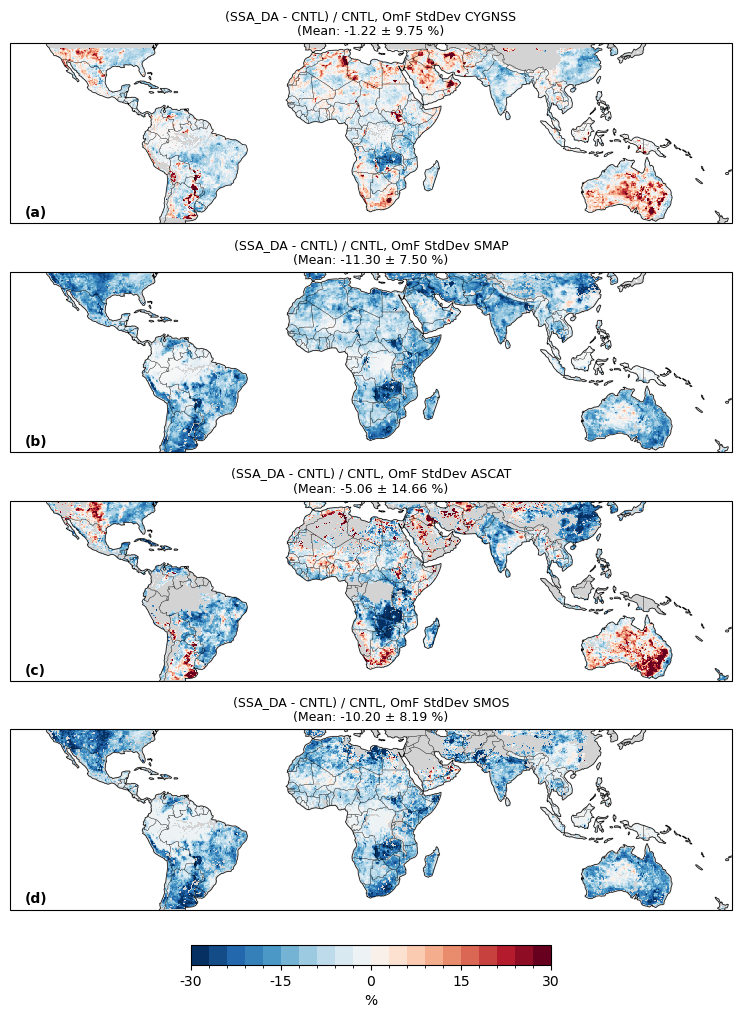

In [26]:
# 4-panel percent-difference maps for SSA_DA vs CNTL (OmF StdDev)
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from common.python.plotting.geospatial_plotting import load_ease_grid, build_ease_grid_mapping

# Helper
def pct_diff(da, ol):
    return np.divide(da - ol, ol, out=np.full_like(ol, np.nan, dtype=float), where=ol != 0) * 100.0

map_array = np.empty([n_tile, 3]); map_array.fill(np.nan)
map_array[:,1] = lon; map_array[:,2] = lat
map_array = map_array.copy()

pct_maps_ssa = {
    'CYGNSS': pct_diff(group_metrics_DA_ssa['CYGNSS']['OmF_stdv'], group_metrics_OL['CYGNSS']['OmF_stdv']),
    'SMAP':   pct_diff(group_metrics_DA_ssa['SMAP']['OmF_stdv'],   group_metrics_OL['SMAP']['OmF_stdv']),
    'ASCAT':  pct_diff(group_metrics_DA_ssa['ASCAT']['OmF_stdv'],  group_metrics_OL['ASCAT']['OmF_stdv']),
    'SMOS':   pct_diff(group_metrics_DA_ssa['SMOS']['OmF_stdv'],   group_metrics_OL['SMOS']['OmF_stdv']),
}

panels = [
    ('CYGNSS', '(a)'),
    ('SMAP',   '(b)'),
    ('ASCAT',  '(c)'),
    ('SMOS',   '(d)'),
]

vmin, vmax = -30.0, 30.0
lats, lons = load_ease_grid(); lats_row, lons_col = lats[:,1], lons[1,:]
lon_grid, lat_grid = np.meshgrid(lons_col, lats_row)

fig, axes = plt.subplots(4, 1, figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()
for ax, (species, lab) in zip(axes, panels):
    data_1d = pct_maps_ssa[species]
    mean_val = np.nanmean(data_1d)
    std_val = np.nanstd(data_1d)
    map_array[:,0] = data_1d
    grid = build_ease_grid_mapping(map_array, lats_row, lons_col)
    sc = ax.pcolormesh(lon_grid, lat_grid, grid, cmap='RdBu_r', vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    ax.add_feature(cfeature.LAND, color='lightgray', zorder=0)
    ax.set_extent(REGION_BOUNDS['cygnss'], crs=ccrs.PlateCarree())
    ax.set_title(f'(SSA_DA - CNTL) / CNTL, OmF StdDev {species}\n(Mean: {mean_val:.2f} ± {std_val:.2f} %)', fontsize=9)
    ax.text(0.02, 0.02, lab, transform=ax.transAxes, fontsize=10, fontweight='bold', va='bottom', ha='left')
    ax.tick_params(labelbottom=False, labelleft=False)

# Shared colorbar
cax = fig.add_axes([0.35, 0.01, 0.30, 0.02])
edges = np.linspace(vmin, vmax, 21)
from matplotlib.colors import BoundaryNorm
from matplotlib.cm import get_cmap
cmap = get_cmap("RdBu_r", len(edges)-1)
norm = BoundaryNorm(edges, cmap.N)
sc.set_cmap(cmap); sc.set_norm(norm)
cbar = fig.colorbar(sc, cax=cax, orientation="horizontal")
cbar.set_ticks([-30, -15, 0, 15, 30])
cbar.ax.set_xticklabels(["-30", "-15", "0", "15", "30"])
cbar.ax.tick_params(labelsize=10)
cbar.set_label('%', fontsize=10)
fig.tight_layout(rect=(0, 0.05, 1, 0.98))
plt.show()


# CYGNSS CD Summary Figures

Plots copied from original IV and TC notebooks (processing unchanged, imports consolidated).

In [27]:
import numpy as np
import pandas as pd
import xarray as xr
import scipy.io as sio
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
from scipy.spatial import cKDTree
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.cm import get_cmap

# repo utilities

def find_repo_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if (p / '.git').exists():
            return p
    return start

here = Path(__file__).resolve().parent if '__file__' in globals() else Path.cwd()
repo_root = find_repo_root(here)
sys.path.append(str(repo_root / 'common' / 'python' / 'plotting'))
sys.path.append(str(repo_root / 'common' / 'python' / 'io'))
sys.path.append(str(repo_root / 'projects' / 'matlab2python' / 'shared' / 'python'))
sys.path.append('../util/shared/python/')

from read_GEOSldas import read_tilecoord

DATA_DIR = Path('/Users/amfox/Desktop/GEOSldas_diagnostics/test_data')
# plotting removed (single-panel plot)


In [28]:
import numpy as np
import pandas as pd
import xarray as xr
import scipy.io as sio
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
from scipy.spatial import cKDTree
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.cm import get_cmap

# repo utilities

def find_repo_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if (p / '.git').exists():
            return p
    return start

here = Path(__file__).resolve().parent if '__file__' in globals() else Path.cwd()
repo_root = find_repo_root(here)
sys.path.append(str(repo_root / 'common' / 'python' / 'plotting'))
sys.path.append(str(repo_root / 'common' / 'python' / 'io'))
sys.path.append(str(repo_root / 'projects' / 'matlab2python' / 'shared' / 'python'))
sys.path.append('../util/shared/python/')

from read_GEOSldas import read_tilecoord

DATA_DIR = Path('/Users/amfox/Desktop/GEOSldas_diagnostics/test_data')
# plotting removed (single-panel plot)


In [29]:

# --------- 1) paths ---------
p_cntl = Path("/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/CYGNSS_Experiments/Evaluation/IVs/ASCL4_SMPL3_OLv8_M36_cd_TC_stats_201808_202405.mat")
p_da   = Path("/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/CYGNSS_Experiments/Evaluation/IVs/ASCL4_SMPL3_DAv8_M36_cd_TC_stats_201808_202405.mat")

# --------- 2) load .mat (squeeze to 1D vectors) ---------
def _vec(x):
    return np.asarray(x).squeeze()

M0 = loadmat(p_cntl, squeeze_me=True, struct_as_record=False)
M1 = loadmat(p_da,   squeeze_me=True, struct_as_record=False)

In [30]:

# expected vars: 'lons','lats','N_sm','Nmin','R2_TC_L3','R2_TC_ASC','R2_TC_mod',
# 'sigma2_L3','sigma2_mod','sigma2_ASC','R_mod_L3','R_mod_ASC','R_ASC_L3',
# 'C_L3_mod','C_mod_ASC','C_L3_ASC'

def _vec(x): return np.asarray(x).squeeze()

def grab(M, name):
    if name not in M:
        raise KeyError(f"Missing '{name}' in file")
    return _vec(M[name])

# --- grid shape from lons/lats ---
lons = grab(M0, "lons")
lats = grab(M0, "lats")

if lons.ndim == 2 and lats.ndim == 2:
    shp = lons.shape  # (nlon, nlat)
else:
    # If saved flat, set to your grid dims and reshape
    nlon, nlat = 406, 964
    shp = (nlon, nlat)
    lons = lons.reshape(shp)
    lats = lats.reshape(shp)

    # preserve TC grid as flat vectors
    lons_tc = lons.flatten()
    lats_tc = lats.flatten()

# Helpers to coerce arrays to 2D grid
def as_grid(M, key, shp):
    a = grab(M, key)
    if a.ndim == 2 and a.shape == shp:
        return a
    if a.size == np.prod(shp):
        return a.reshape(shp)
    # Some MATLAB saves may come as (nlat, nlon); handle simple transpose case
    if a.ndim == 2 and a.shape == (shp[1], shp[0]):
        return a.T
    raise ValueError(f"Field '{key}' has unexpected shape {a.shape}, cannot map to {shp}")

def get_fields(M, shp):
    grid_keys = [
        "N_sm",
        "R2_TC_L3","R2_TC_ASC","R2_TC_mod",
        "sigma2_L3","sigma2_mod","sigma2_ASC",
        "R_mod_L3","R_mod_ASC","R_ASC_L3",
        "C_L3_mod","C_mod_ASC","C_L3_ASC",
    ]
    out = {k: as_grid(M, k, shp) for k in grid_keys}
    # Scalars
    out["Nmin"] = float(grab(M, "Nmin"))
    return out

S0 = get_fields(M0, shp)  # CNTL
S1 = get_fields(M1, shp)  # CYG_DA


In [31]:

# --------- 3) build common-valid mask ---------
# same sampling threshold in both + all fields finite where needed
Nmin = int(np.nanmax(S0["Nmin"]))  # should be same value
Mvalid = (
    (S0["N_sm"] >= Nmin) & (S1["N_sm"] >= Nmin) &
    np.isfinite(S0["R2_TC_mod"]) & np.isfinite(S1["R2_TC_mod"]) &
    np.isfinite(S0["sigma2_mod"]) & np.isfinite(S1["sigma2_mod"])
)

# clamp any R2 slightly outside (0,1] due to rounding
def clamp01(a):
    out = a.copy()
    out[(out <= 0) | (~np.isfinite(out))] = np.nan
    out[out > 1] = 1.0
    return out

R2m0 = clamp01(S0["R2_TC_mod"])
R2m1 = clamp01(S1["R2_TC_mod"])


In [32]:

# --------- 4) compute metrics ---------
# (a) change in R^2 (positive is better)
dR2_mod = np.where(Mvalid, R2m1 - R2m0, np.nan)
pct_R2 = np.where(Mvalid, 100.0*(R2m1/R2m0 - 1), np.nan)  # positive % is better

def robust_sigma_t2(S, tol=1e-12, max_spread=50.0):
    C_l3m  = S["C_L3_mod"].astype(float)
    C_ma   = S["C_mod_ASC"].astype(float)
    C_l3a  = S["C_L3_ASC"].astype(float)

    # three TC permutations for σ_t^2
    s1 = (C_l3m * C_ma)  / C_l3a
    s2 = (C_l3m * C_l3a) / C_ma
    s3 = (C_ma  * C_l3a) / C_l3m
    stack = np.stack([s1, s2, s3], 0)

    # basic validity: finite and positive
    valid = np.isfinite(stack) & (stack > tol)
    sig_t2 = np.nanmedian(np.where(valid, stack, np.nan), axis=0)

    # consistency check: drop pixels where permutations disagree wildly
    smin = np.nanmin(np.where(valid, stack, np.nan), axis=0)
    smax = np.nanmax(np.where(valid, stack, np.nan), axis=0)
    spread = smax / smin
    bad = (~np.isfinite(sig_t2)) | (sig_t2 <= tol) | (~np.isfinite(spread)) | (spread > max_spread)
    sig_t2[bad] = np.nan
    return sig_t2

def direct_fMSE(S):
    """
    Compute fractional MSE directly from TC covariances & error variances.
    S must contain: 'sigma2_mod','sigma2_L3','sigma2_ASC',
                    'C_L3_mod','C_mod_ASC','C_L3_ASC'
    Returns: dict with fMSE_{mod,L3,ASC} and sigma_t2.
    """
    C_L3_mod = S["C_L3_mod"].astype(float)
    C_mod_ASC= S["C_mod_ASC"].astype(float)
    C_L3_ASC = S["C_L3_ASC"].astype(float)

    # Truth (signal) variance from TC geometry
    sigma_t2 = robust_sigma_t2(S)

    bad = (~np.isfinite(sigma_t2)) | (sigma_t2 <= 0)
    fMSE_mod = np.full_like(sigma_t2, np.nan)
    fMSE_L3  = np.full_like(sigma_t2, np.nan)
    fMSE_ASC = np.full_like(sigma_t2, np.nan)

    ok = ~bad
    # Require finite σ² as well
    ok_mod = ok & np.isfinite(S["sigma2_mod"])
    ok_L3  = ok & np.isfinite(S["sigma2_L3"])
    ok_ASC = ok & np.isfinite(S["sigma2_ASC"])

    fMSE_mod[ok_mod] = S["sigma2_mod"][ok_mod] / sigma_t2[ok_mod]
    fMSE_L3[ok_L3]   = S["sigma2_L3"][ok_L3]   / sigma_t2[ok_L3]
    fMSE_ASC[ok_ASC] = S["sigma2_ASC"][ok_ASC] / sigma_t2[ok_ASC]

    # Nonphysical negatives -> NaN
    fMSE_mod[fMSE_mod < 0] = np.nan
    fMSE_L3[fMSE_L3   < 0] = np.nan
    fMSE_ASC[fMSE_ASC < 0] = np.nan

    return dict(fMSE_mod=fMSE_mod, fMSE_L3=fMSE_L3, fMSE_ASC=fMSE_ASC, sigma_t2=sigma_t2)


def fMSE_from_R2(R2):
    fm = (1 - R2) / R2
    fm[(~np.isfinite(fm)) | (fm < 0)] = np.nan
    return fm

# Example usage on your loaded fields S0/S1 (CNTL/DA):
direct0 = direct_fMSE(S0); direct1 = direct_fMSE(S1)
fMSE0_R2 = fMSE_from_R2(S0["R2_TC_mod"])
diff_check = np.nanmax(np.abs(direct0["fMSE_mod"] - fMSE0_R2))
print("max |direct - via R2|:", diff_check)


# fMSE0 = fMSE_from_R2(R2m0)
# fMSE1 = fMSE_from_R2(R2m1)
# dfMSE = np.where(Mvalid, fMSE1 - fMSE0, np.nan)              # negative is good
# pct_fMSE = np.where(Mvalid, 100.0*(fMSE1/fMSE0 - 1), np.nan) # negative % is good

# Direct fMSE from TC covariances
direct0 = direct_fMSE(S0)   # CNTL
direct1 = direct_fMSE(S1)   # CYG_DA

fMSE0 = direct0["fMSE_mod"]
fMSE1 = direct1["fMSE_mod"]

# Valid where both runs have finite fMSE and you already had Nmin, etc.
Mvalid_fmse = Mvalid & np.isfinite(fMSE0) & np.isfinite(fMSE1)

dfMSE = np.full_like(fMSE0, np.nan)
dfMSE[Mvalid_fmse] = fMSE1[Mvalid_fmse] - fMSE0[Mvalid_fmse]      # negative is good

pct_fMSE = np.full_like(fMSE0, np.nan)
ratio = np.full_like(fMSE0, np.nan)
ratio[Mvalid_fmse] = fMSE1[Mvalid_fmse] / fMSE0[Mvalid_fmse]
pct_fMSE[Mvalid_fmse] = 100.0 * (ratio[Mvalid_fmse] - 1.0)        # negative % is good

# (c) change in model error variance (σ^2_mod) and % change
sig20 = S0["sigma2_mod"]; sig21 = S1["sigma2_mod"]
dsig2 = np.where(Mvalid, sig21 - sig20, np.nan)                  # negative is good

# 1) mask tiny baseline sigma2 before % change
p10 = np.nanpercentile(sig20, 10)
baseline_floor = max(1e-8, p10)
good_base = Mvalid & np.isfinite(sig20) & (sig20 > baseline_floor)

pct_sig2 = np.full_like(sig20, np.nan)
pct_sig2[good_base] = 100.0 * (sig21[good_base]/sig20[good_base] - 1.0)

# 2) Robust summaries (don’t use mean±std)
def robust_summary(a, m):
    x = a[m & np.isfinite(a)]
    if x.size == 0: return {"median": np.nan, "IQR": np.nan, "n": 0, "improved_frac": np.nan}
    q25, q50, q75 = np.nanpercentile(x, [25, 50, 75])
    return {
        "median": float(q50),
        "IQR": float(q75 - q25),
        "n": int(x.size),
        "improved_frac": float(np.nanmean((x < 0)))  # negative % = reduction
    }

summ_pct = robust_summary(pct_sig2, good_base)
summ_dR2 = robust_summary(dR2_mod, Mvalid)

print("ΔR²_mod  (median, IQR):", summ_dR2["median"], summ_dR2["IQR"])
print("Fraction tiles with R² improved:", 1 - summ_dR2["improved_frac"])
print("%Δσ²_mod (median, IQR):", summ_pct["median"], summ_pct["IQR"])
print("Fraction tiles with σ² reduced:", summ_pct["improved_frac"])


/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_50535/772074.py:19: RuntimeWarning: All-NaN slice encountered
  sig_t2 = np.nanmedian(np.where(valid, stack, np.nan), axis=0)
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_50535/772074.py:22: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(np.where(valid, stack, np.nan), axis=0)
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_50535/772074.py:23: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(np.where(valid, stack, np.nan), axis=0)


max |direct - via R2|: 81.23483281656671
ΔR²_mod  (median, IQR): 0.027107037882334206 0.05961117215005787
Fraction tiles with R² improved: 0.8732165206508136
%Δσ²_mod (median, IQR): -22.21177618779765 21.248819168271133
Fraction tiles with σ² reduced: 0.9537554747926568


In [33]:
# Flatten dR2_mod for downstream mapping
dR2_mod_vec = dR2_mod.flatten()
dR2_mod_vec = np.asarray(dR2_mod_vec, dtype=float)


In [34]:
# Load aridity/LAI dataset
fn = DATA_DIR / 'CYGNSS_Experiments/Evaluation/IVs/aridity_indices_model_net_rad_20180801_20240630.nc4'
ds = xr.open_dataset(fn, decode_times=True)
ai = ds['AI_clim'].values
lon = ds['lon'].isel(time=1).values
lat = ds['lat'].isel(time=1).values
mean_lai_clim = ds['mean_lai_clim'].values
mean_greeness_clim = ds['mean_greeness_clim'].values if 'mean_greeness_clim' in ds else None
title_time = 'Climatology'


In [35]:
# Load TC observation error variances (sigma2_*) for CYG/SMAP/ASCAT
p_tc_obs = Path('/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/CYGNSS_Experiments/Evaluation/IVs/ASCL4_SMPL3_CYGL3_OLv8_M36_cd_TC_stats_201808_202405.mat')
M2 = loadmat(p_tc_obs, squeeze_me=True, struct_as_record=False)

lons_tc = np.asarray(grab(M2, 'lons')).ravel()
lats_tc = np.asarray(grab(M2, 'lats')).ravel()
sigma2_CYG = np.asarray(grab(M2, 'sigma2_CYG'), dtype=float)
sigma2_L3  = np.asarray(grab(M2, 'sigma2_L3'), dtype=float)
sigma2_ASC = np.asarray(grab(M2, 'sigma2_ASC'), dtype=float)


In [36]:
# Aridity index (AI) prep for downstream multi-panel figures (no plotting here)
ai_flat = np.squeeze(ai)
lon_flat = np.squeeze(lon)
lat_flat = np.squeeze(lat)
n = ai_flat.size

pred_lon_flat = lon_flat
pred_lat_flat = lat_flat

map_array = np.empty((n, 3), dtype=float)
map_array.fill(np.nan)
map_array[:, 0] = ai_flat
map_array[:, 1] = lon_flat
map_array[:, 2] = lat_flat

maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])
print(f"AI_clim {title_time} max {maxval:.3g} min {minval:.3g}")


AI_clim Climatology max 6.19 min 0.00047


In [37]:
# Mean LAI prep for downstream multi-panel figures (no plotting here)
mean_lai_clim = ds['mean_lai_clim'].values  # shape (tile,)
mean_lai_flat = np.squeeze(mean_lai_clim)
map_array = np.empty((n, 3), dtype=float)
map_array.fill(np.nan)
map_array[:, 0] = mean_lai_flat
map_array[:, 1] = lon_flat
map_array[:, 2] = lat_flat

maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])
print(f"mean_lai_clim max {maxval:.3g} min {minval:.3g}")


mean_lai_clim max 5.73 min 0


In [38]:
# Flatten pct_sig2 for downstream mapping
pct_sig2_vec = pct_sig2.flatten()
pct_sig2_vec = np.asarray(pct_sig2_vec, dtype=float)


In [39]:
# ...existing code...
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.spatial import cKDTree
import cartopy.crs as ccrs

# # Ensure coordinate vectors exist for KDTree inputs
# if "lons_vec" not in globals():
#     if "lons" in globals():
#         lons_vec = np.ravel(lons)
#         lats_vec = np.ravel(lats)
#     else:
#         lons_vec = np.ravel(lon_flat)
#         lats_vec = np.ravel(lat_flat)

lons_vec = np.ravel(lons_tc)
lats_vec = np.ravel(lats_tc)        

# inputs expected in notebook namespace: lons_vec, lats_vec, lon_flat, lat_flat, pct_sig2_vec, sigma2_CYG
# build points
vec_pts = np.column_stack((np.ravel(lons_vec), np.ravel(lats_vec)))
flat_pts = np.column_stack((np.ravel(lon_flat), np.ravel(lat_flat)))

# build KDTree and query
kdtree = cKDTree(vec_pts)
_, idxs = kdtree.query(flat_pts, k=1)

# map the vector field pct_sig2_vec to the flattened grid order
pct_sig2_flat_to_map = pct_sig2_vec[idxs]

# reshape to grid like lon_flat (if lon_flat is 1D, keep 1D)
try:
    grid_shape = lon_flat.shape
except NameError:
    grid_shape = pct_sig2_flat_to_map.shape
pct_map = pct_sig2_flat_to_map.reshape(grid_shape)



In [40]:

target_dR2 = np.ravel(dR2_mod_vec)[idxs]
target_dR2_name = "Δ R²_mod (DA - CNTL)"
# Clip extreme outliers, keep between 1 and 99 percentiles
p_low, p_high = np.nanpercentile(target_dR2, [1, 99])
target_dR2 = np.where((target_dR2 < p_low) | (target_dR2 > p_high), np.nan, target_dR2)
print(f"target_dR2 clipped to 1-99% range: {p_low:.3g} to {p_high:.3g}")

target_pct_sig2 = np.ravel(pct_sig2_vec)[idxs]
target_pct_sig2_name = "% Δ σ²_mod (DA vs CNTL)"
# Clip extreme outliers, keep between 1 and 99 percentiles
p_low, p_high = np.nanpercentile(target_pct_sig2, [1, 99])
target_pct_sig2 = np.where((target_pct_sig2 < p_low) | (target_pct_sig2 > p_high), np.nan, target_pct_sig2)
print(f"target_pct_sig2 clipped to 1-99% range: {p_low:.3g} to {p_high:.3g}")

pred_sigma2_CYG = np.ravel(sigma2_CYG)[idxs]
p_low, p_high = np.nanpercentile(pred_sigma2_CYG, [1, 99])
pred_sigma2_CYG = np.where((pred_sigma2_CYG < p_low) | (pred_sigma2_CYG > p_high), np.nan, pred_sigma2_CYG)
pred_sigma2_CYG_name = "CYG L3 Obs Err Variance"

pred_ai = np.ravel(ai_flat)
p_low, p_high = np.nanpercentile(pred_ai, [1, 99])
pred_ai = np.where((pred_ai < p_low) | (pred_ai > p_high), np.nan, pred_ai)
pred_ai_name = "Aridity Index (P/PET)"

pred_mean_lai = np.ravel(mean_lai_flat)
p_low, p_high = np.nanpercentile(pred_mean_lai, [1, 99])
pred_mean_lai = np.where((pred_mean_lai < p_low) | (pred_mean_lai > p_high), np.nan, pred_mean_lai)
pred_mean_lai_name = "Mean Annual LAI (m2/m2)"


pred_sigma2_mod0 = np.ravel(S0['sigma2_mod'])[idxs]
p_low, p_high = np.nanpercentile(pred_sigma2_mod0, [1, 99])
pred_sigma2_mod0 = np.where((pred_sigma2_mod0 < p_low) | (pred_sigma2_mod0 > p_high), np.nan, pred_sigma2_mod0)
pred_sigma2_mod0_name = "CNTL Model Error Variance"


target_dR2 clipped to 1-99% range: -0.0668 to 0.253
target_pct_sig2 clipped to 1-99% range: -69.9 to 19.3


In [41]:
#import numpy as np
#import pandas as pd
#import sys
#from pathlib import Path

#from read_GEOSldas import read_tilecoord

# Load tile coordinates to get tile_id, com_lon, com_lat
ftc = '/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/CYGNSS_Experiments/DAv8_M36_cd/DAv8_M36_cd/output/SMAP_EASEv2_M36_GLOBAL/rc_out/DAv8_M36_cd.ldas_tilecoord.bin'

tc = read_tilecoord(ftc)
tile_id = np.array(tc['tile_id'], dtype=int)
lon_flat = tc['com_lon']
lat_flat = tc['com_lat']
com_lon = tc['com_lon']
com_lat = tc['com_lat']
n_tiles = len(tile_id)


mosaic_path = "/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/mosaic_veg_typs_fracs"

# --- thresholds & codes ---
PRIMARY_THRESH = 49.0
BARE_MAX = 10.0          # total < 0.10  -> bare
SPARSE_MAX = 20.0        # 0.10 <= total <= 0.20 -> sparse
MIXED_MIN = 20.0         # total > 0.20 and primary <= 0.50 -> mixed

BARE_CODE   = 0
MIXED_CODE  = 7
SPARSE_CODE = 8

# --- read whitespace-delimited text file ---
cols = ["tile_index","pfaf_code","primary_veg_type","secondary_veg_type",
        "primary_veg_frac","secondary_veg_frac","canopy_height","ASCATz0"]

records = []
with open(mosaic_path, "r") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        parts = line.split()
        if len(parts) != 8:
            parts = parts[-8:]  # keep the last 8 fields if a leading counter exists
        ti, pf, pty, sty = map(int, parts[:4])
        pfra, sfra, canh, z0 = map(float, parts[4:])
        records.append((ti, pf, pty, sty, pfra, sfra, canh, z0))

df = pd.DataFrame(records, columns=cols).set_index("tile_index")

# --- align to tile_id order ---
sub = df.reindex(tile_id)

p_type = sub["primary_veg_type"].astype("float")
p_frac = sub["primary_veg_frac"]
s_frac = sub["secondary_veg_frac"]
tot_frac = p_frac + s_frac

veg_code = np.full(len(sub), np.nan)

# Rule A: bare if total < 0.10
mask_bare = tot_frac < BARE_MAX
veg_code[mask_bare] = BARE_CODE

# Rule B: sparse if 0.10 <= total <= 0.20
mask_sparse = (~mask_bare) & (tot_frac <= SPARSE_MAX)
veg_code[mask_sparse] = SPARSE_CODE

# Rule C: primary type if primary > 0.50 (and not bare/sparse)
mask_primary = np.isnan(veg_code) & (p_frac > PRIMARY_THRESH)
veg_code[mask_primary] = p_type[mask_primary]

# Rule D: mixed if total > 0.20 and primary <= 0.50 (and not already set)
mask_mixed = np.isnan(veg_code) & (tot_frac > MIXED_MIN) & (p_frac <= PRIMARY_THRESH)
veg_code[mask_mixed] = MIXED_CODE

# Fallback: any remaining (e.g., missing tiles) -> sparse (or choose another)
veg_code[np.isnan(veg_code)] = SPARSE_CODE

veg_type_out = veg_code.astype(int)
total_fraction = tot_frac.fillna(0.0).to_numpy()

# Outputs:
#  - veg_type_out: integer array aligned with tile_id (1–6 from file, plus 7=mixed, 8=sparse, 0=bare)
#  - total_fraction: float array aligned with tile_id (primary + secondary)

print(len(veg_type_out), veg_type_out)

print("minimum primary fraction:", np.nanmin(p_frac))
print("minimum primary + secondary fraction:", np.nanmin(total_fraction))


reading from /Users/amfox/Desktop/GEOSldas_diagnostics/test_data/CYGNSS_Experiments/DAv8_M36_cd/DAv8_M36_cd/output/SMAP_EASEv2_M36_GLOBAL/rc_out/DAv8_M36_cd.ldas_tilecoord.bin
done reading file
70773 [4 4 4 ... 4 1 4]
minimum primary fraction: 50.0
minimum primary + secondary fraction: 99.99


In [42]:
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature

lat = np.asarray(com_lat)
lon = np.asarray(com_lon)

# bring longitudes to [-180, 180]
lon = np.where(lon > 180.0, lon - 360.0, lon)

# ---- labels for legend (codes from your mosaic definition + mixed/sparse/bare) ----
label_map = {
    0: "Bare",
    1: "Broadleaf Evergreen",
    2: "Broadleaf Deciduous",
    3: "Needleleaf",
    4: "Grassland",
    5: "Broadleaf Shrubs",
    6: "Dwarf Trees",
    7: "Mixed",
    8: "Sparse",
}

# only plot classes that appear
classes_present = np.unique(veg_type_out[np.isfinite(veg_type_out)])

# # ---- figure ----
# proj = ccrs.PlateCarree()
# fig = plt.figure(figsize=(10, 6))
# ax = plt.axes(projection=proj)

# # set extent with small padding
# lat_min, lat_max = np.nanmin(lat), np.nanmax(lat)
# lon_min, lon_max = np.nanmin(lon), np.nanmax(lon)
# dlat = max(2.0, 0.05 * (lat_max - lat_min + 1e-6))
# dlon = max(2.0, 0.05 * (lon_max - lon_min + 1e-6))
# ax.set_extent([lon_min - dlon, lon_max + dlon, lat_min - dlat, lat_max + dlat], crs=proj)

# # map features
# ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
# ax.add_feature(cfeature.BORDERS, linewidth=0.4)
# gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, linewidth=0.3)
# gl.top_labels = False
# gl.right_labels = False

# # plot each class as its own scatter (lets Matplotlib assign distinct default colors)
# handles = []
# labels = []
# for code in classes_present:
#     mask = veg_type_out == code
#     if not np.any(mask):
#         continue
#     sc = ax.scatter(lon[mask], lat[mask], s=10, transform=proj, label=label_map.get(int(code), f"Class {int(code)}"))
#     handles.append(sc)
#     labels.append(label_map.get(int(code), f"Class {int(code)}"))

# # legend
# leg = ax.legend(handles, labels, title="Vegetation Type", loc="lower left", frameon=True, fontsize=8, title_fontsize=9)

# ax.set_title("Primary Vegetation Type (with Mixed/Sparse/Bare) for Experiment Tiles", fontsize=12, pad=10)
# plt.tight_layout()

In [43]:
#import matplotlib.pyplot as plt

def box_by_veg(y, yname):
    label_map = {
        0: "Bare", 1: "Broadleaf Evergreen", 2: "Broadleaf Deciduous",
        3: "Needleleaf", 4: "Grassland", 5: "Broadleaf Shrubs",
        6: "Dwarf Trees", 7: "Mixed", 8: "Sparse",
    }
    order = [1,2,3,4,5,6,7,8,0]  # tweak if you like
    data, labels = [], []
    for k in order:
        sel = np.isfinite(veg_type_out) & (veg_type_out == k) & np.isfinite(y)
        if sel.any():
            data.append(y[sel])
            labels.append(f"{label_map[k]} (n={sel.sum():,})")
    plt.figure(figsize=(11,4))
    plt.boxplot(data, labels=labels, showfliers=True)
    plt.axhline(0, ls="--", lw=1)
    plt.title(yname)
    plt.xticks(rotation=20, ha="right")
    plt.tight_layout()
    plt.show()

#box_by_veg(target_dR2, target_dR2_name)
#box_by_veg(target_pct_sig2, target_pct_sig2_name)


In [44]:
# Inputs assumed to exist:
#   pred_ai, pred_ai_name
#   pred_mean_lai, pred_mean_lai_name
#   pred_mean_greeness, pred_mean_greeness_name
#   target_dR2, target_dR2_name
#   target_pct_sig2, target_pct_sig2_name

def bin_and_plot(predictor, predictor_name, targets, q=5, dropna=True,
                 bins=None, labels=None, include_lowest=True, right=True):
    """
    Bin a predictor and plot target distributions per bin.

    If `bins` is provided (list-like), uses fixed bins via pd.cut.
    Otherwise, uses quantile bins via pd.qcut with q quantiles.

    targets = list of (target_array, target_name) tuples.
    """
    # assemble DataFrame
    df = pd.DataFrame({predictor_name: predictor})
    for t_arr, t_name in targets:
        df[t_name] = t_arr

    # clean NaNs/infs
    df = df.replace([np.inf, -np.inf], np.nan)
    if dropna:
        df = df.dropna(subset=[predictor_name])
    if df.empty:
        print(f"{predictor_name}: no valid rows after dropna.")
        return

    # choose binning method
    if bins is not None:
        # fixed bins
        df["bin"] = pd.cut(df[predictor_name], bins=bins, labels=labels,
                           include_lowest=include_lowest, right=right)
        bin_order = df["bin"].cat.categories
        bin_desc = f"fixed bins ({len(bin_order)})"
    else:
        # quantile bins; reduce q if duplicates happen
        q_use = q
        while True:
            try:
                df["bin"] = pd.qcut(df[predictor_name], q=q_use, duplicates="drop")
                break
            except ValueError:
                q_use -= 1
                if q_use < 2:
                    df["bin"] = pd.cut(df[predictor_name], bins=1)
                    break
        bin_order = df["bin"].cat.categories
        bin_desc = f"quantile bins (q={q_use})"

    # per-target plots and summaries
    for t_arr, t_name in targets:
        desc = (df.groupby("bin")[t_name]
                  .agg(count="count",
                       median=lambda x: np.nanmedian(x),
                       mean="mean",
                       std="std",
                       q25=lambda x: np.nanpercentile(x, 25),
                       q75=lambda x: np.nanpercentile(x, 75)))
        print(f"\n=== {t_name} by {predictor_name} {bin_desc} ===")
        print(desc)

        # prepare boxplot data & labels
        data, xlabels = [], []
        for b in bin_order:
            vals = df.loc[df["bin"] == b, t_name].dropna().values
            data.append(vals)
            xlabels.append(f"{b}\n(n={len(vals):,})")

        # plot
        plt.figure(figsize=(10, 4))
        plt.boxplot(data, labels=xlabels, showfliers=True)
        plt.axhline(0.0, ls="--", lw=1)
        plt.title(f"{t_name} by {predictor_name} — {bin_desc}")
        plt.xticks(rotation=15, ha="right")
        plt.tight_layout()
        plt.show()
     


targets_list = [
    (target_dR2, target_dR2_name),
    (target_pct_sig2, target_pct_sig2_name),
]

# 1) LAI with *fixed* bins (rounded, physically meaningful)
lai_bins   = [0.0, 0.10, 0.50, 1.30, 2.60, np.inf]
lai_labels = ["0–0.10", "0.10–0.50", "0.50–1.30", "1.30–2.60", ">2.60"]

/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_50535/2110159536.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('RdBu_r', len(edges)-1)
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_50535/2110159536.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=(0, 0.08, 1, 1))


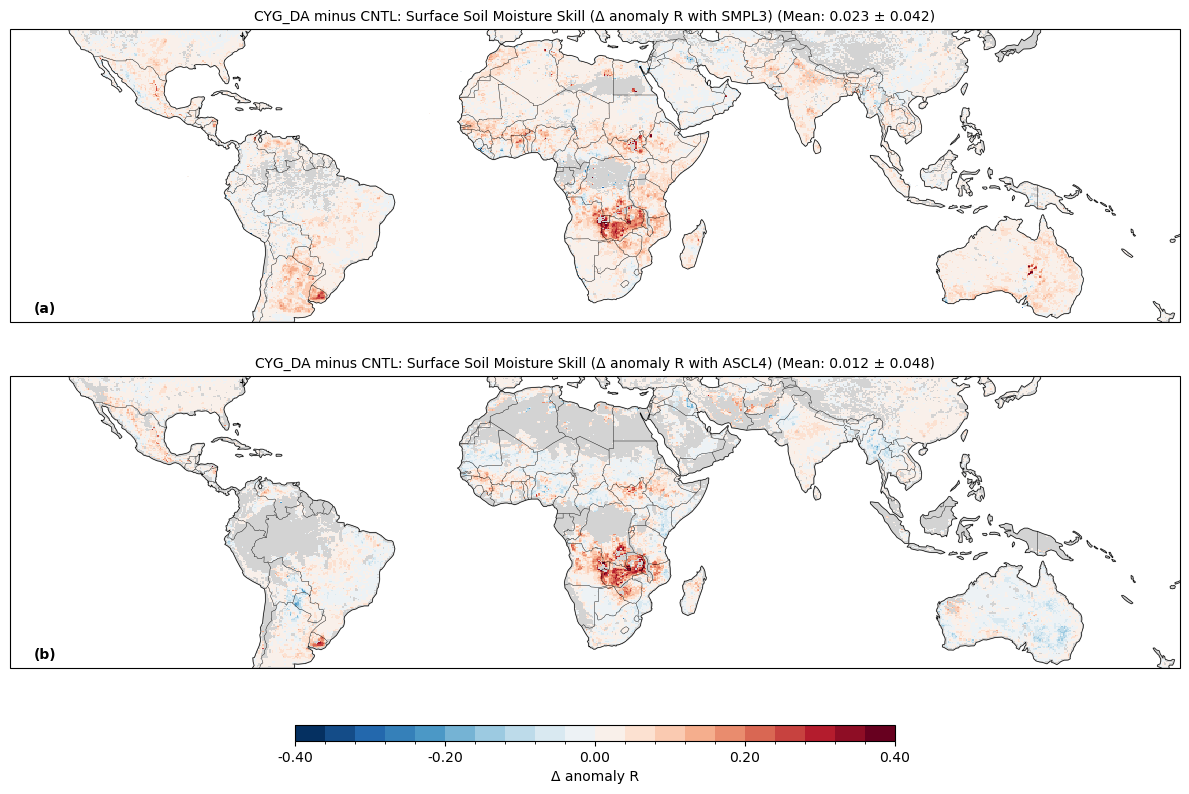

In [45]:
# Two-panel: Δ anomaly R (SMPL3 top, ASCL4 bottom) with discrete colorbars (pcolormesh)
paths = [
    (DATA_DIR / 'CYGNSS_Experiments/Evaluation/IVs/Rdiff_DAv8_M36_cd_minus_OLv8_M36_cd_SMPL3.mat', 'Δ anomaly R with SMPL3', '(a)'),
    (DATA_DIR / 'CYGNSS_Experiments/Evaluation/IVs/Rdiff_DAv8_M36_cd_minus_OLv8_M36_cd_ASCL4.mat', 'Δ anomaly R with ASCL4', '(b)')
]

fig, axes = plt.subplots(2, 1, figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
vmin, vmax = -0.4, 0.4
edges = np.linspace(vmin, vmax, 21)
cmap = get_cmap('RdBu_r', len(edges)-1)
norm = BoundaryNorm(edges, cmap.N)
lats_ease, lons_ease = load_ease_grid(); lats_row, lons_col = lats_ease[:,1], lons_ease[1,:]
lon_grid, lat_grid = np.meshgrid(lons_col, lats_row)
map_array = None
for ax, (path, label, lab) in zip(axes, paths):
    mat = sio.loadmat(path)
    rdiff = np.squeeze(mat['Rdiff_vector'])
    lons = np.squeeze(mat['lons'])
    lats = np.squeeze(mat['lats'])
    mean_val = np.nanmean(rdiff); std_val = np.nanstd(rdiff)
    if map_array is None:
        map_array = np.empty([len(lons), 3]); map_array.fill(np.nan)
        map_array[:,1] = lons; map_array[:,2] = lats
    map_array[:,0] = rdiff
    grid = build_ease_grid_mapping(map_array, lats_row, lons_col)
    sc = ax.pcolormesh(lon_grid, lat_grid, grid, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    ax.add_feature(cfeature.LAND, color='lightgray', zorder=0)
    ax.set_extent(REGION_BOUNDS['cygnss'], crs=ccrs.PlateCarree())
    ax.set_title(f'CYG_DA minus CNTL: Surface Soil Moisture Skill ({label}) (Mean: {mean_val:.2g} ± {std_val:.2g})', fontsize=10)
    ax.text(0.02, 0.02, lab, transform=ax.transAxes, fontsize=10, fontweight='bold', va='bottom', ha='left')
    ax.tick_params(labelbottom=False, labelleft=False)

cax = fig.add_axes([0.25, 0.05, 0.50, 0.02])
cbar = fig.colorbar(sc, cax=cax, orientation='horizontal')
cbar.set_label('Δ anomaly R', fontsize=10)
cbar.set_ticks(edges[::5])
cbar.ax.set_xticklabels([f"{t:.2f}" for t in edges[::5]])
cbar.ax.tick_params(labelsize=10)
fig.tight_layout(rect=(0, 0.08, 1, 1))
plt.show()


/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_50535/3815442301.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_lai = get_cmap('YlGn', len(edges_lai)-1)
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_50535/3815442301.py:70: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_ai = get_cmap('Spectral', len(a_edges)-1)


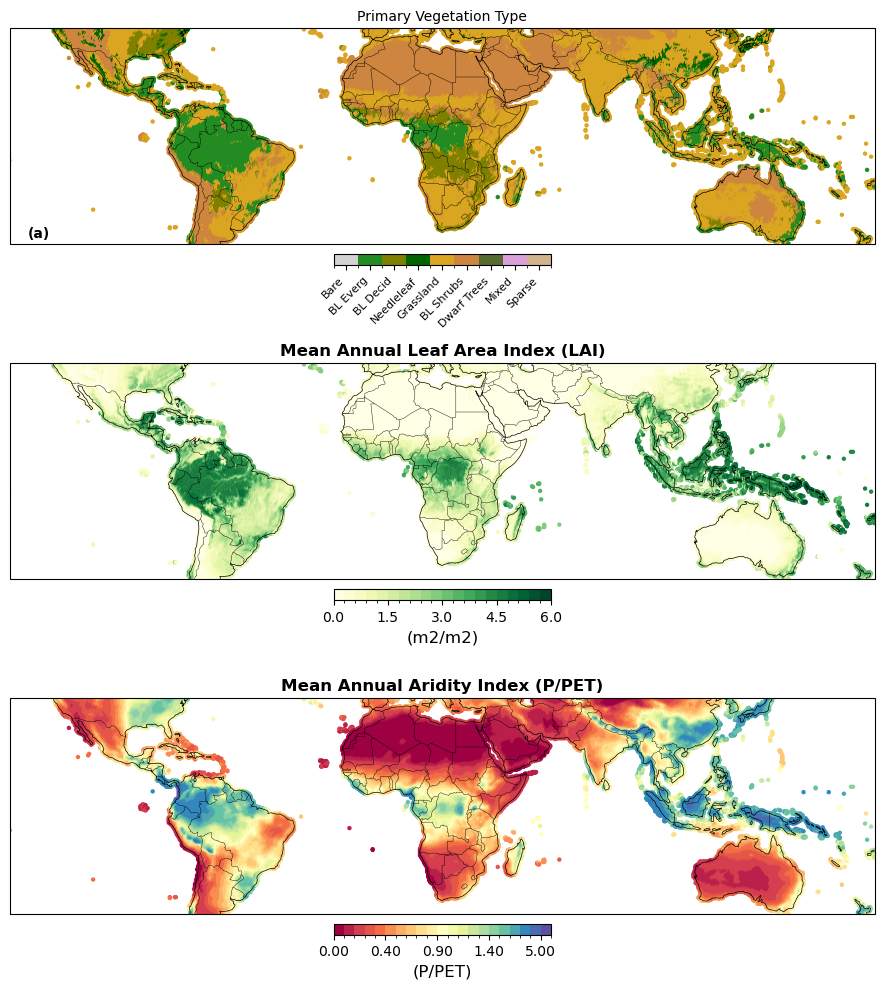

In [46]:
# 3x1: Vegetation type, Mean LAI, Aridity Index
label_map = {0:"Bare",1:"BL Everg",2:"BL Decid",3:"Needleleaf",4:"Grassland",5:"BL Shrubs",6:"Dwarf Trees",7:"Mixed",8:"Sparse"}
classes_present = np.unique(veg_type_out[np.isfinite(veg_type_out)])
veg_colors = ['lightgray','forestgreen','olive','darkgreen','goldenrod','peru','darkolivegreen','plum','tan']
veg_cmap = ListedColormap(veg_colors[:len(label_map)])
veg_bounds = np.arange(-0.5, 9.5, 1.0)

# Flatten AI/LAI grids
lon_flat_ai = np.squeeze(lon)
lat_flat_ai = np.squeeze(lat)
ai_flat = np.squeeze(ai)
mean_lai_flat = np.squeeze(mean_lai_clim)

fig, axes = plt.subplots(3, 1, figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Vegetation panel
a = axes[0]
lon_plot = np.where(com_lon > 180.0, com_lon - 360.0, com_lon)
sc0 = a.scatter(lon_plot, com_lat, c=veg_type_out, cmap=veg_cmap, norm=BoundaryNorm(veg_bounds, veg_cmap.N), s=10, edgecolor='none', transform=ccrs.PlateCarree())
a.add_feature(cfeature.COASTLINE, linewidth=0.5)
a.add_feature(cfeature.BORDERS, linewidth=0.3)
a.add_feature(cfeature.LAND, color='lightgray', zorder=0)
a.set_extent(REGION_BOUNDS['cygnss'], crs=ccrs.PlateCarree())
a.set_title('Primary Vegetation Type', fontsize=10)
a.text(0.02, 0.02, '(a)', transform=a.transAxes, fontsize=10, fontweight='bold', va='bottom', ha='left')
a.tick_params(labelbottom=False, labelleft=False)
cbar0 = fig.colorbar(sc0, ax=a, orientation='horizontal', pad=0.04, fraction=0.046, boundaries=veg_bounds)
# cbar0.set_label('Veg Type', fontsize=9)
cbar0.set_ticks(list(label_map.keys()))
cbar0.set_ticklabels([label_map[k] for k in label_map])
for label in cbar0.ax.get_xticklabels():
    label.set_rotation(45)
    label.set_ha('right')
cbar0.ax.tick_params(labelsize=8)

# Mean LAI panel
ax1 = axes[1]
vmin_lai, vmax_lai = 0.0, 6.0
edges_lai = np.linspace(vmin_lai, vmax_lai, 21)
cmap_lai = get_cmap('YlGn', len(edges_lai)-1)
norm_lai = BoundaryNorm(edges_lai, cmap_lai.N)
# attempt reshape to 2D if possible, else keep 1D scatter
try:
    grid_shape = mean_lai_clim.shape
    if len(grid_shape)==2:
        lon_grid = lon_flat_ai.reshape(grid_shape)
        lat_grid = lat_flat_ai.reshape(grid_shape)
        data_grid = mean_lai_flat.reshape(grid_shape)
        sc1 = ax1.pcolormesh(lon_grid, lat_grid, data_grid, cmap=cmap_lai, norm=norm_lai, transform=ccrs.PlateCarree())
    else:
        sc1 = ax1.scatter(lon_flat_ai, lat_flat_ai, c=mean_lai_flat, cmap=cmap_lai, norm=norm_lai, s=10, edgecolor='none', transform=ccrs.PlateCarree())
except Exception:
    sc1 = ax1.scatter(lon_flat_ai, lat_flat_ai, c=mean_lai_flat, cmap=cmap_lai, norm=norm_lai, s=10, edgecolor='none', transform=ccrs.PlateCarree())
ax1.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax1.add_feature(cfeature.BORDERS, linewidth=0.3)
ax1.add_feature(cfeature.LAND, color='lightgray', zorder=0)
ax1.set_extent(REGION_BOUNDS['cygnss'], crs=ccrs.PlateCarree())
ax1.set_title('Mean Annual Leaf Area Index (LAI)', fontsize=12, fontweight='bold')
#ax1.text(0.02, 0.02, '(b)', transform=ax1.transAxes, fontsize=10, fontweight='bold', va='bottom', ha='left')
ax1.tick_params(labelbottom=False, labelleft=False)
cbar1 = fig.colorbar(sc1, ax=ax1, orientation='horizontal', pad=0.04, fraction=0.046)
cbar1.set_label('(m2/m2)', fontsize=12)
cbar1.set_ticks(edges_lai[::5])
cbar1.ax.set_xticklabels([f"{t:.1f}" for t in edges_lai[::5]])
cbar1.ax.tick_params(labelsize=10)

# Aridity panel
ax2 = axes[2]
a_edges = np.array([0.00,0.05,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,1.00,1.10,1.20,1.30,1.40,1.50,1.75,2.00,3.00,5.00,10.00])
cmap_ai = get_cmap('Spectral', len(a_edges)-1)
norm_ai = BoundaryNorm(a_edges, cmap_ai.N)
try:
    grid_shape = ai.shape
    if len(grid_shape)==2:
        lon_grid = lon_flat_ai.reshape(grid_shape)
        lat_grid = lat_flat_ai.reshape(grid_shape)
        data_grid = ai_flat.reshape(grid_shape)
        sc2 = ax2.pcolormesh(lon_grid, lat_grid, data_grid, cmap=cmap_ai, norm=norm_ai, transform=ccrs.PlateCarree())
    else:
        sc2 = ax2.scatter(lon_flat_ai, lat_flat_ai, c=ai_flat, cmap=cmap_ai, norm=norm_ai, s=10, edgecolor='none', transform=ccrs.PlateCarree())
except Exception:
    sc2 = ax2.scatter(lon_flat_ai, lat_flat_ai, c=ai_flat, cmap=cmap_ai, norm=norm_ai, s=10, edgecolor='none', transform=ccrs.PlateCarree())
ax2.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax2.add_feature(cfeature.BORDERS, linewidth=0.3)
ax2.add_feature(cfeature.LAND, color='lightgray', zorder=0)
ax2.set_extent(REGION_BOUNDS['cygnss'], crs=ccrs.PlateCarree())
ax2.set_title('Mean Annual Aridity Index (P/PET)', fontsize=12, fontweight='bold')
#ax2.text(0.02, 0.02, '(c)', transform=ax2.transAxes, fontsize=10, fontweight='bold', va='bottom', ha='left')
ax2.tick_params(labelbottom=False, labelleft=False)
cbar2 = fig.colorbar(sc2, ax=ax2, orientation='horizontal', pad=0.04, fraction=0.046, boundaries=a_edges)
cbar2.set_label('(P/PET)', fontsize=12)
# set tick labels roughly every few bins
positions = a_edges[::5]
cbar2.set_ticks(positions)
cbar2.ax.set_xticklabels([f"{t:.2f}" for t in positions])
cbar2.ax.tick_params(labelsize=10)

plt.tight_layout()
plt.show()


In [47]:
# Combined 6x1 boxplots with cross-masked targets (same n for ΔR² and %Δσ²)
import pandas as pd

veg_labels = {0: "Bare", 1: "Broadleaf Evergreen", 2: "Broadleaf Deciduous", 3: "Needleleaf", 4: "Grassland", 5: "Broadleaf Shrubs", 6: "Dwarf Trees", 7: "Mixed", 8: "Sparse"}
veg_order = [1,2,3,4,5,6,7,8,0]

veg_vec = veg_type_out.flatten()
tr_dR2 = target_dR2
tr_pct = target_pct_sig2
lai_vals = np.clip(mean_lai_flat, 0, None)
ai_vals = np.clip(ai_flat, 0, None)

# align lengths and build common mask
min_len = min(len(veg_vec), len(tr_dR2), len(tr_pct), len(lai_vals), len(ai_vals))
veg_vec = veg_vec[:min_len]; tr_dR2 = tr_dR2[:min_len]; tr_pct = tr_pct[:min_len]; lai_vals = lai_vals[:min_len]; ai_vals = ai_vals[:min_len]
common_mask = np.isfinite(veg_vec) & np.isfinite(tr_dR2) & np.isfinite(tr_pct) & np.isfinite(lai_vals) & np.isfinite(ai_vals)
veg_vec = veg_vec[common_mask]; tr_dR2 = tr_dR2[common_mask]; tr_pct = tr_pct[common_mask]; lai_vals = lai_vals[common_mask]; ai_vals = ai_vals[common_mask]

# fig, axes = plt.subplots(6, 1, figsize=(10, 22))

# # Helper to make a boxplot for categorical predictor

# def box_cat(ax, cats, data, title, ylabel, labels_map=None, order=None):
#     data_list=[]; labels=[]
#     if order is None:
#         order = np.unique(cats[np.isfinite(cats)])
#     for k in order:
#         sel = np.isfinite(cats) & (cats==k) & np.isfinite(data)
#         if sel.any():
#             data_list.append(data[sel])
#             lab = labels_map.get(k, str(k)) if labels_map else str(k)
#             labels.append(f"{lab} (n={sel.sum():,})")
#     ax.boxplot(data_list, labels=labels, showfliers=True, flierprops={'markersize':3, 'marker': 'o'})
#     ax.axhline(0, ls='--', lw=1, color='gray')
#     ax.set_title(title)
#     ax.set_ylabel(ylabel)
#     for tick in ax.get_xticklabels():
#         tick.set_rotation(15)

# # Veg panels
# box_cat(axes[0], veg_vec, tr_dR2, 'Δ R² by Vegetation Class', 'Δ R² (CYG_DA - CNTL)', veg_labels, veg_order)
# box_cat(axes[1], veg_vec, tr_pct, '% Δ σ² by Vegetation Class', '% Δ σ² ((CYG_DA - CNTL) / CNTL)', veg_labels, veg_order)

# # LAI bins
# lai_bins   = [0.0, 0.10, 0.50, 1.30, 2.60, np.inf]
# lai_df = pd.DataFrame({'lai': lai_vals, 'dR2': tr_dR2, 'pct': tr_pct}).replace([np.inf,-np.inf], np.nan).dropna(subset=['lai'])
# lai_df['bin'] = pd.cut(lai_df['lai'], bins=lai_bins, include_lowest=True)
# for ax, col, title, ylabel in [(axes[2], 'dR2', 'Δ R² by Leaf Area Index', 'Δ R² (CYG_DA - CNTL)'), (axes[3], 'pct', '% Δ σ² by Leaf Area Index', '% Δ σ² ((CYG_DA - CNTL) / CNTL)')]:
#     data_list=[]; labels=[]
#     for lbl in lai_df['bin'].cat.categories:
#         vals = lai_df.loc[lai_df['bin']==lbl, col].dropna().values
#         left = max(0, lbl.left); right = lbl.right if lbl.right != float('inf') else np.inf
#         lab = f'{left:.2g}–{right:.2g}' if right != np.inf else f'>{left:.2g}'
#         data_list.append(vals)
#         labels.append(f"{lab} (n={len(vals):,})")
#     ax.boxplot(data_list, labels=labels, showfliers=True, flierprops={'markersize':3, 'marker': 'o'})
#     ax.axhline(0, ls='--', lw=1, color='gray')
#     ax.set_title(title)
#     ax.set_ylabel(ylabel)
#     for tick in ax.get_xticklabels():
#         tick.set_rotation(20)

# # Aridity quantile bins (q=5)
# ai_df = pd.DataFrame({'ai': ai_vals, 'dR2': tr_dR2, 'pct': tr_pct}).replace([np.inf,-np.inf], np.nan).dropna(subset=['ai'])
# try:
#     ai_df['bin'] = pd.qcut(ai_df['ai'], q=5, duplicates='drop')
# except Exception:
#     ai_df['bin'] = pd.cut(ai_df['ai'], bins=5)
# for ax, col, title, ylabel in [(axes[4], 'dR2', 'Δ R² by Aridity Index', 'Δ R² (CYG_DA - CNTL)'), (axes[5], 'pct', '% Δ σ² by Aridity Index', '% Δ σ² ((CYG_DA - CNTL) / CNTL)')]:
#     data_list=[]; labels=[]
#     for lbl in ai_df['bin'].cat.categories:
#         vals = ai_df.loc[ai_df['bin']==lbl, col].dropna().values
#         left = max(0, lbl.left); right = lbl.right if lbl.right != float('inf') else np.inf
#         lab = f'{left:.2g}–{right:.2g}' if right != np.inf else f'>{left:.2g}'
#         data_list.append(vals)
#         labels.append(f"{lab} (n={len(vals):,})")
#     ax.boxplot(data_list, labels=labels, showfliers=True, flierprops={'markersize':3, 'marker': 'o'})
#     ax.axhline(0, ls='--', lw=1, color='gray')
#     ax.set_title(title)
#     ax.set_ylabel(ylabel)
#     for tick in ax.get_xticklabels():
#         tick.set_rotation(20)


# # add panel labels
# for ax, lab in zip(axes, ['(a)','(b)','(c)','(d)','(e)','(f)']):
#     ax.text(0.02, 0.95, lab, transform=ax.transAxes, fontsize=10, fontweight='bold', va='top', ha='left')

# # hide x ticklabels on R² panels
# for idx in [0,2,4]:
#     axes[idx].tick_params(labelbottom=False)

# plt.tight_layout()
# # bring (b) closer to (a), (d) closer to (c), (f) closer to (e)
# pos_list = [ax.get_position() for ax in axes]
# offsets = [0.0, 0.02, 0.0, 0.02, 0.0, 0.02]
# for ax, pos, off in zip(axes, pos_list, offsets):
#     ax.set_position([pos.x0, pos.y0 + off, pos.width, pos.height])

# plt.show()


In [48]:
# Compute inverted %Δσ² (CNTL-EXPT) so positive = better
pct_sig2_inv = -pct_sig2
pct_sig2_inv_vec = pct_sig2_inv.flatten()
pct_sig2_inv_masked = np.where(Mvalid, pct_sig2_inv, np.nan)
try:
    target_pct_sig2_inv = -target_pct_sig2
except Exception:
    target_pct_sig2_inv = None


/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_50535/1273437518.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap(cmap_name, len(edges)-1)
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_50535/1273437518.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap(cmap_name, len(edges)-1)


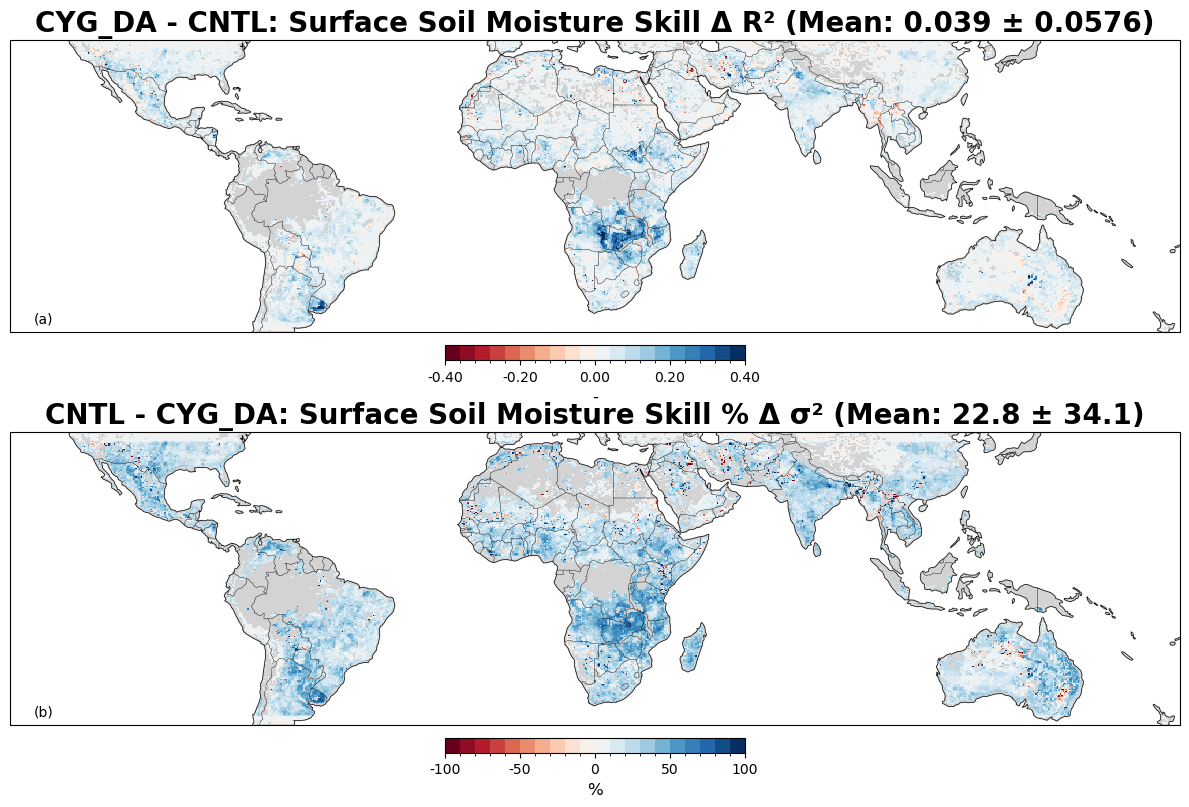

In [49]:
# Two-panel: Δ R²_mod and % Δ σ²_mod (CNTL-EXPT)
vals = [
    (dR2_mod, 'CYG_DA - CNTL: Surface Soil Moisture Skill Δ R²', 'RdBu', (-0.4, 0.4), '(a)', '-'),
    (pct_sig2_inv, 'CNTL - CYG_DA: Surface Soil Moisture Skill % Δ σ²', 'RdBu', (-100.0, 100.0), '(b)', '%')
]
lats_ease, lons_ease = load_ease_grid(); lats_row, lons_col = lats_ease[:,1], lons_ease[1,:]
lon_grid, lat_grid = np.meshgrid(lons_col, lats_row)
map_array_tmp = np.empty([lons.size, 3]); map_array_tmp.fill(np.nan); map_array_tmp[:,1]=lons.flatten(); map_array_tmp[:,2]=lats.flatten()

fig, axes = plt.subplots(2, 1, figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
for ax, (data_grid, title, cmap_name, clim, lab, units) in zip(axes, vals):
    vmin, vmax = clim
    edges = np.linspace(vmin, vmax, 21)
    cmap = get_cmap(cmap_name, len(edges)-1)
    norm = BoundaryNorm(edges, cmap.N)
    data_flat = data_grid.flatten()
    mean_val = np.nanmean(data_flat); std_val = np.nanstd(data_flat)
    map_array_tmp[:,0] = data_flat
    grid = build_ease_grid_mapping(map_array_tmp, lats_row, lons_col)
    sc = ax.pcolormesh(lon_grid, lat_grid, grid, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    ax.add_feature(cfeature.LAND, color='lightgray', zorder=0)
    ax.set_extent(REGION_BOUNDS['cygnss'], crs=ccrs.PlateCarree())
    ax.set_title(f"{title} (Mean: {mean_val:.3g} ± {std_val:.3g})", fontsize=20, fontweight='bold')
    ax.text(0.02, 0.02, lab, transform=ax.transAxes, fontsize=10, va='bottom', ha='left')
    ax.tick_params(labelbottom=False, labelleft=False)
    cbar = fig.colorbar(sc, ax=ax, orientation='horizontal', pad=0.04, fraction=0.046)
    cbar.set_label(units, fontsize=12)
    cbar.set_ticks(edges[::5])
    cbar.ax.set_xticklabels([f"{t:.2f}" if units=='-' else f"{t:.0f}" for t in edges[::5]])
    cbar.ax.tick_params(labelsize=10)

plt.tight_layout()
plt.show()


/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_50535/4035942934.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_list, labels=labels, showfliers=True, flierprops={'markersize':3, 'marker': 'o'})
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_50535/4035942934.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_list, labels=labels, showfliers=True, flierprops={'markersize':3, 'marker': 'o'})
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_50535/4035942934.py:60: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_list, labels=labels, showf

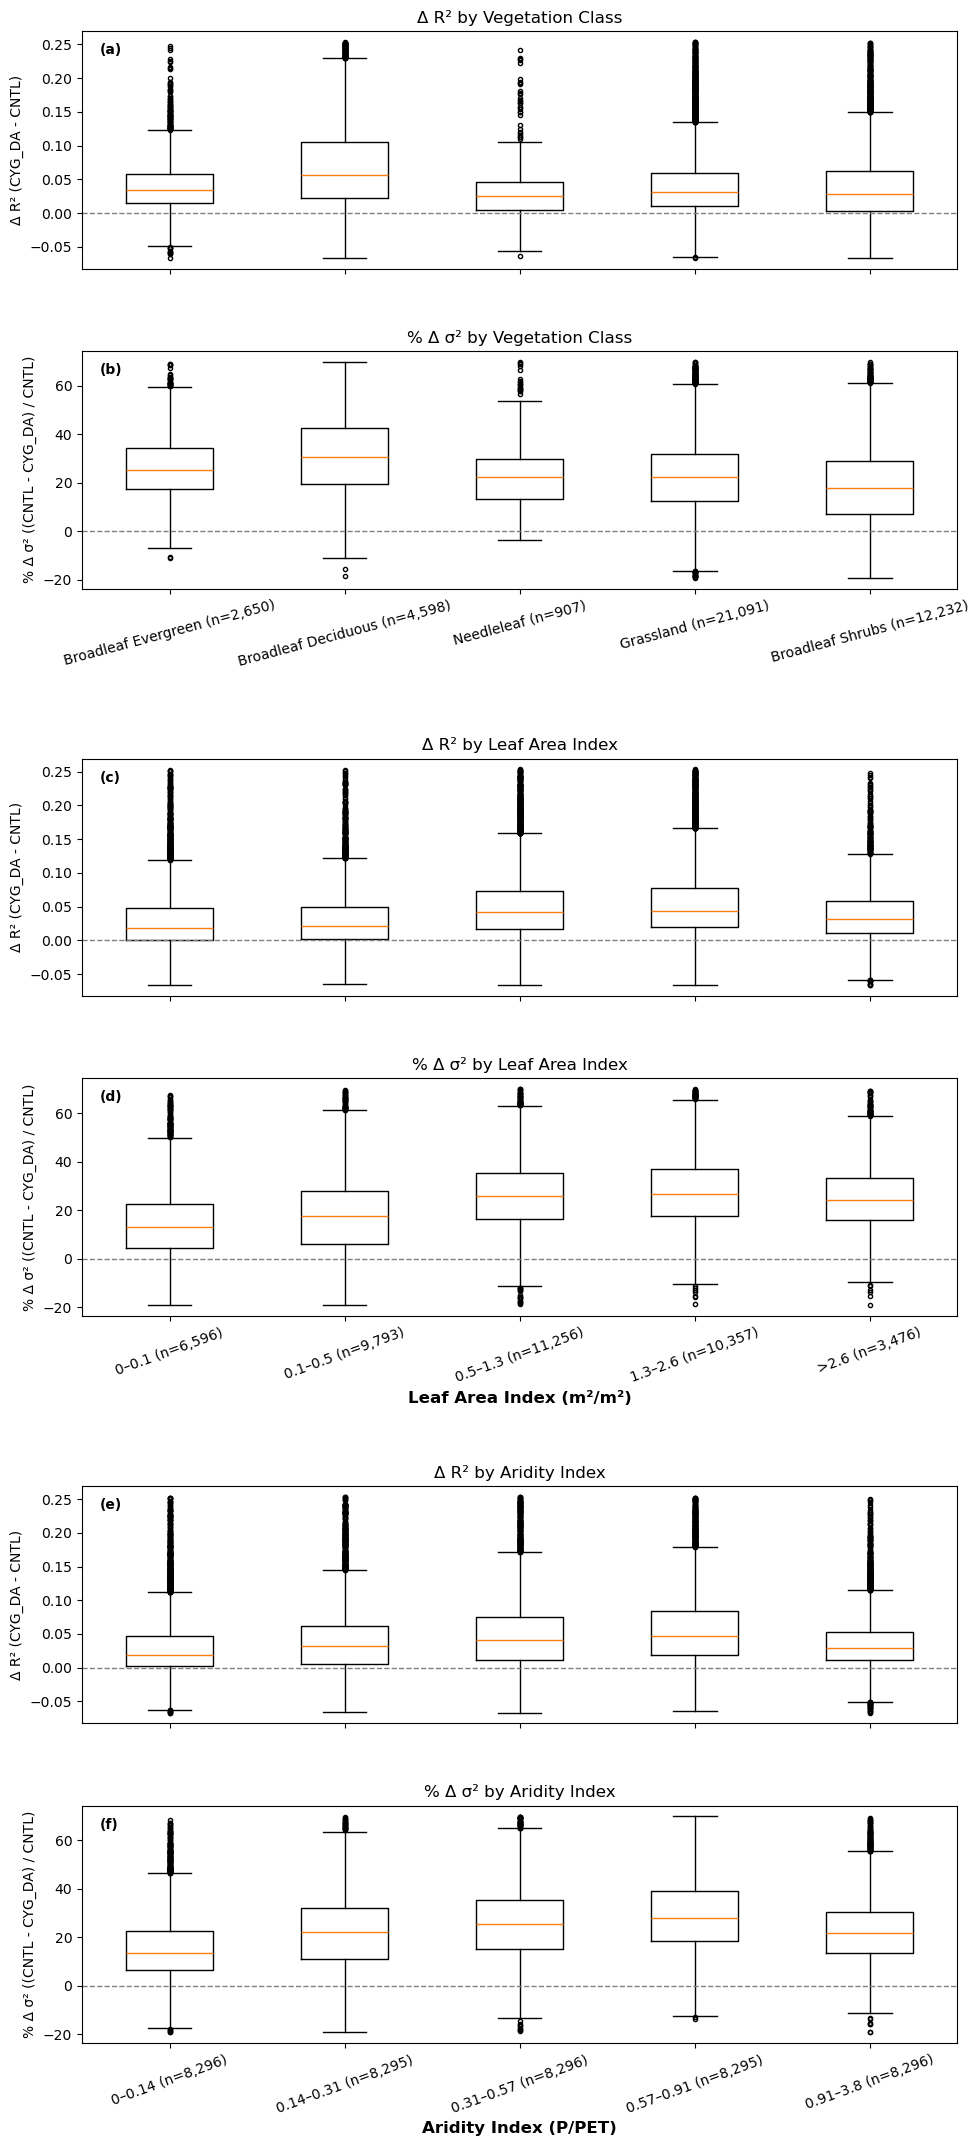

In [50]:
# Combined 6x1 boxplots (CNTL-EXPT %Δσ²)
import pandas as pd

veg_labels = {0: "Bare", 1: "Broadleaf Evergreen", 2: "Broadleaf Deciduous", 3: "Needleleaf", 4: "Grassland", 5: "Broadleaf Shrubs", 6: "Dwarf Trees", 7: "Mixed", 8: "Sparse"}
veg_order = [1,2,3,4,5,6,7,8,0]

veg_vec = veg_type_out.flatten()
tr_dR2 = target_dR2
try:
    tr_pct = target_pct_sig2_inv
except Exception:
    tr_pct = pct_sig2_inv_vec

lai_vals = np.clip(mean_lai_flat, 0, None)
ai_vals = np.clip(ai_flat, 0, None)

# align lengths and build common mask
min_len = min(len(veg_vec), len(tr_dR2), len(tr_pct), len(lai_vals), len(ai_vals))
veg_vec = veg_vec[:min_len]; tr_dR2 = tr_dR2[:min_len]; tr_pct = tr_pct[:min_len]; lai_vals = lai_vals[:min_len]; ai_vals = ai_vals[:min_len]
common_mask = np.isfinite(veg_vec) & np.isfinite(tr_dR2) & np.isfinite(tr_pct) & np.isfinite(lai_vals) & np.isfinite(ai_vals)
veg_vec = veg_vec[common_mask]; tr_dR2 = tr_dR2[common_mask]; tr_pct = tr_pct[common_mask]; lai_vals = lai_vals[common_mask]; ai_vals = ai_vals[common_mask]

fig, axes = plt.subplots(6, 1, figsize=(10, 22))

# Helper to make a boxplot for categorical predictor

def box_cat(ax, cats, data, title, ylabel, labels_map=None, order=None):
    data_list=[]; labels=[]
    if order is None:
        order = np.unique(cats[np.isfinite(cats)])
    for k in order:
        sel = np.isfinite(cats) & (cats==k) & np.isfinite(data)
        if sel.any():
            data_list.append(data[sel])
            lab = labels_map.get(k, str(k)) if labels_map else str(k)
            labels.append(f"{lab} (n={sel.sum():,})")
    ax.boxplot(data_list, labels=labels, showfliers=True, flierprops={'markersize':3, 'marker': 'o'})
    ax.axhline(0, ls='--', lw=1, color='gray')
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    for tick in ax.get_xticklabels():
        tick.set_rotation(15)

# Veg panels
box_cat(axes[0], veg_vec, tr_dR2, 'Δ R² by Vegetation Class', 'Δ R² (CYG_DA - CNTL)', veg_labels, veg_order)
box_cat(axes[1], veg_vec, tr_pct, '% Δ σ² by Vegetation Class', '% Δ σ² ((CNTL - CYG_DA) / CNTL)', veg_labels, veg_order)

# LAI bins
lai_bins   = [0.0, 0.10, 0.50, 1.30, 2.60, np.inf]
lai_df = pd.DataFrame({'lai': lai_vals, 'dR2': tr_dR2, 'pct': tr_pct}).replace([np.inf,-np.inf], np.nan).dropna(subset=['lai'])
lai_df['bin'] = pd.cut(lai_df['lai'], bins=lai_bins, include_lowest=True)
for ax, col, title, ylabel in [(axes[2], 'dR2', 'Δ R² by Leaf Area Index', 'Δ R² (CYG_DA - CNTL)'), (axes[3], 'pct', '% Δ σ² by Leaf Area Index', '% Δ σ² ((CNTL - CYG_DA) / CNTL)')]:
    data_list=[]; labels=[]
    for lbl in lai_df['bin'].cat.categories:
        vals = lai_df.loc[lai_df['bin']==lbl, col].dropna().values
        left = max(0, lbl.left); right = lbl.right if lbl.right != float('inf') else np.inf
        lab = f'{left:.2g}–{right:.2g}' if right != np.inf else f'>{left:.2g}'
        data_list.append(vals)
        labels.append(f"{lab} (n={len(vals):,})")
    ax.boxplot(data_list, labels=labels, showfliers=True, flierprops={'markersize':3, 'marker': 'o'})
    ax.axhline(0, ls='--', lw=1, color='gray')
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    if ax == axes[3]:
        ax.set_xlabel('Leaf Area Index (m²/m²)', fontsize=12, fontweight='bold')
    for tick in ax.get_xticklabels():
        tick.set_rotation(20)

# Aridity quantile bins (q=5)
ai_df = pd.DataFrame({'ai': ai_vals, 'dR2': tr_dR2, 'pct': tr_pct}).replace([np.inf,-np.inf], np.nan).dropna(subset=['ai'])
try:
    ai_df['bin'] = pd.qcut(ai_df['ai'], q=5, duplicates='drop')
except Exception:
    ai_df['bin'] = pd.cut(ai_df['ai'], bins=5)
for ax, col, title, ylabel in [(axes[4], 'dR2', 'Δ R² by Aridity Index', 'Δ R² (CYG_DA - CNTL)'), (axes[5], 'pct', '% Δ σ² by Aridity Index', '% Δ σ² ((CNTL - CYG_DA) / CNTL)')]:
    data_list=[]; labels=[]
    for lbl in ai_df['bin'].cat.categories:
        vals = ai_df.loc[ai_df['bin']==lbl, col].dropna().values
        left = max(0, lbl.left); right = lbl.right if lbl.right != float('inf') else np.inf
        lab = f'{left:.2g}–{right:.2g}' if right != np.inf else f'>{left:.2g}'
        data_list.append(vals)
        labels.append(f"{lab} (n={len(vals):,})")
    ax.boxplot(data_list, labels=labels, showfliers=True, flierprops={'markersize':3, 'marker': 'o'})
    ax.axhline(0, ls='--', lw=1, color='gray')
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    if ax == axes[5]:
        ax.set_xlabel('Aridity Index (P/PET)', fontsize=12, fontweight='bold')
    for tick in ax.get_xticklabels():
        tick.set_rotation(20)


# add panel labels
for ax, lab in zip(axes, ['(a)','(b)','(c)','(d)','(e)','(f)']):
    ax.text(0.02, 0.95, lab, transform=ax.transAxes, fontsize=10, fontweight='bold', va='top', ha='left')

# hide x ticklabels on R² panels
for idx in [0,2,4]:
    axes[idx].tick_params(labelbottom=False)

plt.tight_layout()
# bring (b) closer to (a), (d) closer to (c), (f) closer to (e)
pos_list = [ax.get_position() for ax in axes]
offsets = [0.0, 0.02, 0.0, 0.02, 0.0, 0.02]
for ax, pos, off in zip(axes, pos_list, offsets):
    ax.set_position([pos.x0, pos.y0 + off, pos.width, pos.height])

plt.show()

In [51]:
# Load Δ anomaly R with ASCL4 and map to TC grid
from scipy.spatial import cKDTree

ascl4_path = DATA_DIR / 'CYGNSS_Experiments/Evaluation/IVs/Rdiff_DAv8_M36_cd_minus_OLv8_M36_cd_ASCL4.mat'
mat_ascl4 = sio.loadmat(ascl4_path)
rdiff_ascl4 = np.squeeze(mat_ascl4['Rdiff_vector'])
lon_ascl4 = np.squeeze(mat_ascl4['lons'])
lat_ascl4 = np.squeeze(mat_ascl4['lats'])

src_pts = np.column_stack((lon_ascl4, lat_ascl4))
tgt_pts = np.column_stack((pred_lon_flat, pred_lat_flat))  # TC grid
kd = cKDTree(src_pts)
_, nn_idx = kd.query(tgt_pts, k=1)
rdiff_ascl4_tc = rdiff_ascl4[nn_idx]


/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_50535/49818482.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot(data_list, labels=labels, showfliers=True, flierprops={'markersize':3, 'marker':'o'})
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_50535/49818482.py:52: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(data_list, labels=labels, showfliers=True, flierprops={'markersize':3, 'marker':'o'})
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_50535/49818482.py:74: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[2].boxplot(data_list, labels=labels

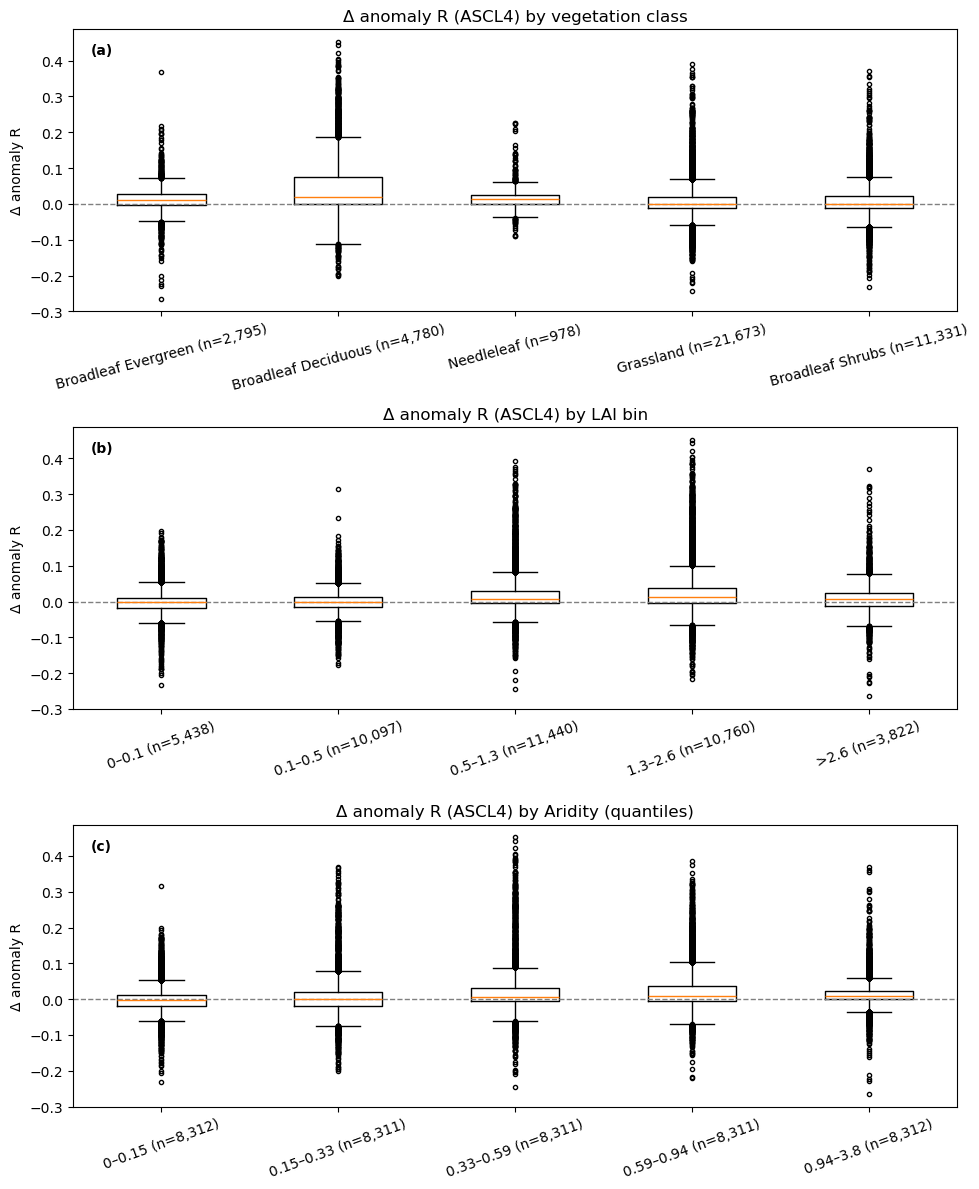

In [52]:
# 3x1 boxplots: Δ anomaly R with ASCL4 (mapped to TC grid)
import pandas as pd

veg_vec = veg_type_out.flatten()
target_rdiff = rdiff_ascl4_tc
lai_vals = np.clip(mean_lai_flat, 0, None)
ai_vals = np.clip(ai_flat, 0, None)

min_len = min(len(veg_vec), len(target_rdiff), len(lai_vals), len(ai_vals))
veg_vec = veg_vec[:min_len]
target_rdiff = target_rdiff[:min_len]
lai_vals = lai_vals[:min_len]
ai_vals = ai_vals[:min_len]

mask = np.isfinite(veg_vec) & np.isfinite(target_rdiff) & np.isfinite(lai_vals) & np.isfinite(ai_vals)
veg_vec = veg_vec[mask]
target_rdiff = target_rdiff[mask]
lai_vals = lai_vals[mask]
ai_vals = ai_vals[mask]

fig, axes = plt.subplots(3, 1, figsize=(10, 12))

# Vegetation
veg_labels = {0: "Bare", 1: "Broadleaf Evergreen", 2: "Broadleaf Deciduous", 3: "Needleleaf", 4: "Grassland", 5: "Broadleaf Shrubs", 6: "Dwarf Trees", 7: "Mixed", 8: "Sparse"}
veg_order = [1,2,3,4,5,6,7,8,0]
data_list=[]; labels=[]
for k in veg_order:
    sel = (veg_vec==k)
    if sel.any():
        data_list.append(target_rdiff[sel])
        labels.append(f"{veg_labels[k]} (n={sel.sum():,})")
axes[0].boxplot(data_list, labels=labels, showfliers=True, flierprops={'markersize':3, 'marker':'o'})
axes[0].axhline(0, ls='--', lw=1, color='gray')
axes[0].set_title('Δ anomaly R (ASCL4) by vegetation class')
axes[0].set_ylabel('Δ anomaly R')
axes[0].tick_params(labelbottom=True)
axes[0].text(0.02, 0.95, '(a)', transform=axes[0].transAxes, fontsize=10, fontweight='bold', va='top', ha='left')
for t in axes[0].get_xticklabels():
    t.set_rotation(15)

# LAI bins
lai_bins   = [0.0, 0.10, 0.50, 1.30, 2.60, np.inf]
lai_df = pd.DataFrame({'lai': lai_vals, 'rdiff': target_rdiff}).replace([np.inf,-np.inf], np.nan).dropna(subset=['lai'])
lai_df['bin'] = pd.cut(lai_df['lai'], bins=lai_bins, include_lowest=True)
data_list=[]; labels=[]
for lbl in lai_df['bin'].cat.categories:
    vals = lai_df.loc[lai_df['bin']==lbl, 'rdiff'].dropna().values
    left = max(0, lbl.left); right = lbl.right if lbl.right != float('inf') else np.inf
    lab = f'{left:.2g}–{right:.2g}' if right != np.inf else f'>{left:.2g}'
    data_list.append(vals)
    labels.append(f"{lab} (n={len(vals):,})")
axes[1].boxplot(data_list, labels=labels, showfliers=True, flierprops={'markersize':3, 'marker':'o'})
axes[1].axhline(0, ls='--', lw=1, color='gray')
axes[1].set_title('Δ anomaly R (ASCL4) by LAI bin')
axes[1].set_ylabel('Δ anomaly R')
axes[1].tick_params(labelbottom=True)
axes[1].text(0.02, 0.95, '(b)', transform=axes[1].transAxes, fontsize=10, fontweight='bold', va='top', ha='left')
for t in axes[1].get_xticklabels():
    t.set_rotation(20)

# Aridity quantile bins
ai_df = pd.DataFrame({'ai': ai_vals, 'rdiff': target_rdiff}).replace([np.inf,-np.inf], np.nan).dropna(subset=['ai'])
try:
    ai_df['bin'] = pd.qcut(ai_df['ai'], q=5, duplicates='drop')
except Exception:
    ai_df['bin'] = pd.cut(ai_df['ai'], bins=5)
data_list=[]; labels=[]
for lbl in ai_df['bin'].cat.categories:
    vals = ai_df.loc[ai_df['bin']==lbl, 'rdiff'].dropna().values
    left = max(0, lbl.left); right = lbl.right if lbl.right != float('inf') else np.inf
    lab = f'{left:.2g}–{right:.2g}' if right != np.inf else f'>{left:.2g}'
    data_list.append(vals)
    labels.append(f"{lab} (n={len(vals):,})")
axes[2].boxplot(data_list, labels=labels, showfliers=True, flierprops={'markersize':3, 'marker':'o'})
axes[2].axhline(0, ls='--', lw=1, color='gray')
axes[2].set_title('Δ anomaly R (ASCL4) by Aridity (quantiles)')
axes[2].set_ylabel('Δ anomaly R')
axes[2].text(0.02, 0.95, '(c)', transform=axes[2].transAxes, fontsize=10, fontweight='bold', va='top', ha='left')
for t in axes[2].get_xticklabels():
    t.set_rotation(20)

plt.tight_layout()
plt.show()


In [53]:
# Scatter: CNTL sigma2_mod aligned to target grid vs ΔR²_mod and %Δσ²_mod
sig20_flat = S0["sigma2_mod"].flatten()
tr_dR2_al = target_dR2
tr_pct_al = target_pct_sig2

# Use the existing KDTree mapping index to align to the same grid
sig20_al = sig20_flat[idxs]


mask = np.isfinite(sig20_al) & np.isfinite(tr_dR2_al) & np.isfinite(tr_pct_al)
sig20_al = sig20_al[mask]
tr_dR2_al = tr_dR2_al[mask]
tr_pct_al = tr_pct_al[mask]


In [54]:
# Boxplots: ΔR²_mod and %Δσ²_mod by sigma2_mod quantiles
import pandas as pd

q = 5  # choose quantile count
df_sig = pd.DataFrame({
    "sig20": sig20_al,
    "dR2": tr_dR2_al,
    "pct": tr_pct_al,
}).replace([np.inf, -np.inf], np.nan).dropna()

try:
    df_sig["bin"] = pd.qcut(df_sig["sig20"], q=q, duplicates="drop")
except Exception:
    df_sig["bin"] = pd.cut(df_sig["sig20"], bins=q)

/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_50535/2883493099.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels, showfliers=True, flierprops={"markersize": 2, "marker": "o"})
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_50535/2883493099.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels, showfliers=True, flierprops={"markersize": 2, "marker": "o"})


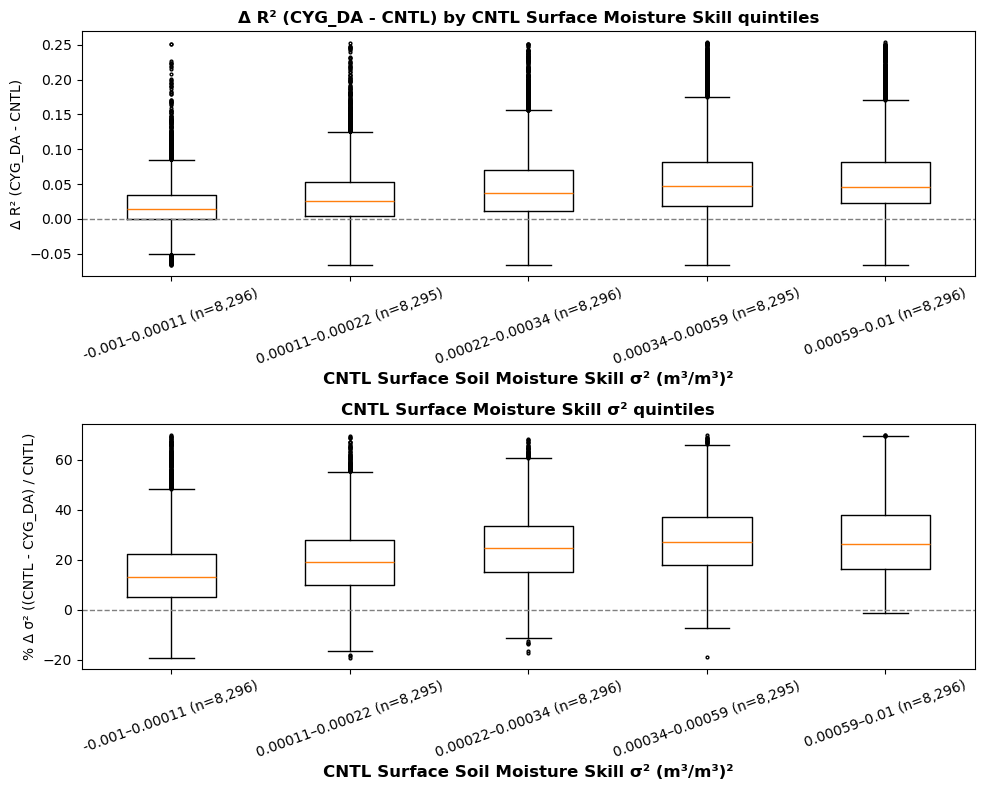

In [55]:
# Boxplots: ΔR²_mod and inverted %Δσ²_mod by sigma2_mod quantiles
import pandas as pd

tr_pct_inv_al = -tr_pct_al  # CNTL - CYG_DA normalized by CNTL

q = 5  # choose quantile count
df_sig_inv = pd.DataFrame({
    "sig20": sig20_al,
    "dR2": tr_dR2_al,
    "pct": tr_pct_inv_al,
}).replace([np.inf, -np.inf], np.nan).dropna()

try:
    df_sig_inv["bin"] = pd.qcut(df_sig_inv["sig20"], q=q, duplicates="drop")
except Exception:
    df_sig_inv["bin"] = pd.cut(df_sig_inv["sig20"], bins=q)

fig, axes = plt.subplots(2, 1, figsize=(10, 8))
for ax, col, title in [
    (axes[0], "dR2", "Δ R² (CYG_DA - CNTL) by CNTL Surface Moisture Skill quintiles"),
    (axes[1], "pct", "CNTL Surface Moisture Skill σ² quintiles"),
]:
    data, labels = [], []
    for lbl in df_sig_inv["bin"].cat.categories:
        vals = df_sig_inv.loc[df_sig_inv["bin"] == lbl, col].values
        data.append(vals)
        labels.append(f"{lbl.left:.2g}–{lbl.right:.2g} (n={len(vals):,})")
    ax.boxplot(data, labels=labels, showfliers=True, flierprops={"markersize": 2, "marker": "o"})
    ax.axhline(0, ls="--", lw=1, color="gray")
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_ylabel("Δ R² (CYG_DA - CNTL)" if col == "dR2" else "% Δ σ² ((CNTL - CYG_DA) / CNTL)")
    for tick in ax.get_xticklabels():
        tick.set_rotation(20)
    ax.set_xlabel("CNTL Surface Soil Moisture Skill σ² (m³/m³)²", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_50535/3539998505.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap(cmap_name, len(edges) - 1)
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_50535/3539998505.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap(cmap_name, len(edges) - 1)


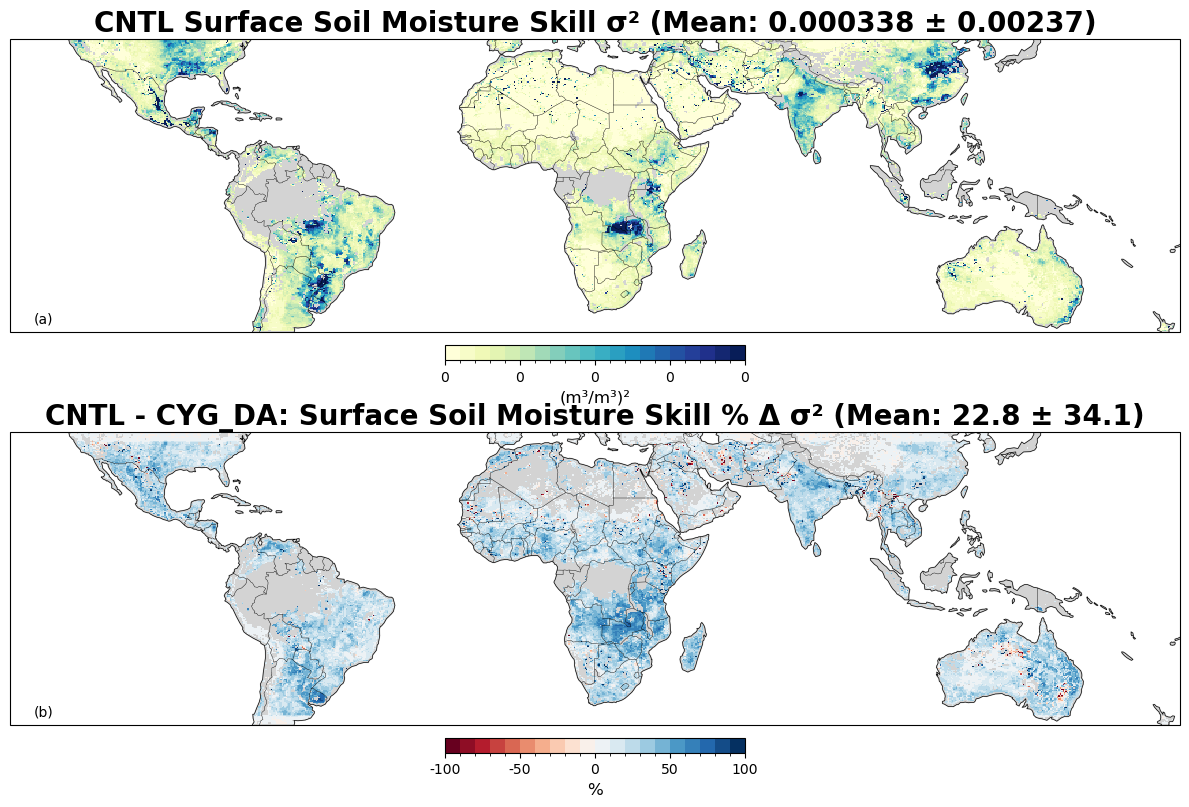

In [56]:
# Two-panel: CNTL sigma2_mod (a) and CNTL minus CYG_DA % Δ σ² (b)
vals = [
    (S0["sigma2_mod"], 'CNTL Surface Soil Moisture Skill σ²', 'YlGnBu', (0.0, 2e-3), '(a)', '(m³/m³)²'),
    (pct_sig2_inv, 'CNTL - CYG_DA: Surface Soil Moisture Skill % Δ σ²', 'RdBu', (-100.0, 100.0), '(b)', '%'),
]

lats_ease, lons_ease = load_ease_grid(); lats_row, lons_col = lats_ease[:,1], lons_ease[1,:]
lon_grid, lat_grid = np.meshgrid(lons_col, lats_row)
map_array_tmp = np.empty([lons.size, 3]); map_array_tmp.fill(np.nan); map_array_tmp[:,1] = lons.flatten(); map_array_tmp[:,2] = lats.flatten()

fig, axes = plt.subplots(2, 1, figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
for ax, (data_grid, title, cmap_name, clim, lab, units) in zip(axes, vals):
    data_grid = np.asarray(data_grid)
    if units == '-':  # sigma2_mod, clip negative values
        data_grid = np.where(np.isfinite(data_grid), np.maximum(data_grid, 0.0), np.nan)
    data_flat = data_grid.flatten()
    if clim is None:
        vmin, vmax = np.nanpercentile(data_flat, [1, 99])
        vmin = max(vmin, 0.0) if units == '-' else vmin
    else:
        vmin, vmax = clim
    if not np.isfinite(vmin) or not np.isfinite(vmax):
        vmin, vmax = np.nanmin(data_flat), np.nanmax(data_flat)
    edges = np.linspace(vmin, vmax, 21)
    cmap = get_cmap(cmap_name, len(edges) - 1)
    norm = BoundaryNorm(edges, cmap.N)
    mean_val = np.nanmean(data_flat); std_val = np.nanstd(data_flat)
    map_array_tmp[:,0] = data_flat
    grid = build_ease_grid_mapping(map_array_tmp, lats_row, lons_col)
    sc = ax.pcolormesh(lon_grid, lat_grid, grid, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    ax.add_feature(cfeature.LAND, color='lightgray', zorder=0)
    ax.set_extent(REGION_BOUNDS['cygnss'], crs=ccrs.PlateCarree())
    ax.set_title(f"{title} (Mean: {mean_val:.3g} ± {std_val:.3g})", fontsize=20, fontweight='bold')
    ax.text(0.02, 0.02, lab, transform=ax.transAxes, fontsize=10, va='bottom', ha='left')
    ax.tick_params(labelbottom=False, labelleft=False)
    cbar = fig.colorbar(sc, ax=ax, orientation='horizontal', pad=0.04, fraction=0.046)
    cbar.set_label(units, fontsize=12)
    cbar.set_ticks(edges[::5])
    cbar.ax.set_xticklabels([f"{t:.2e}" if units=='-' else f"{t:.0f}" for t in edges[::5]])
    cbar.ax.tick_params(labelsize=10)

plt.tight_layout()
plt.show()


/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_50535/1571225073.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('YlGnBu', len(edges) - 1)


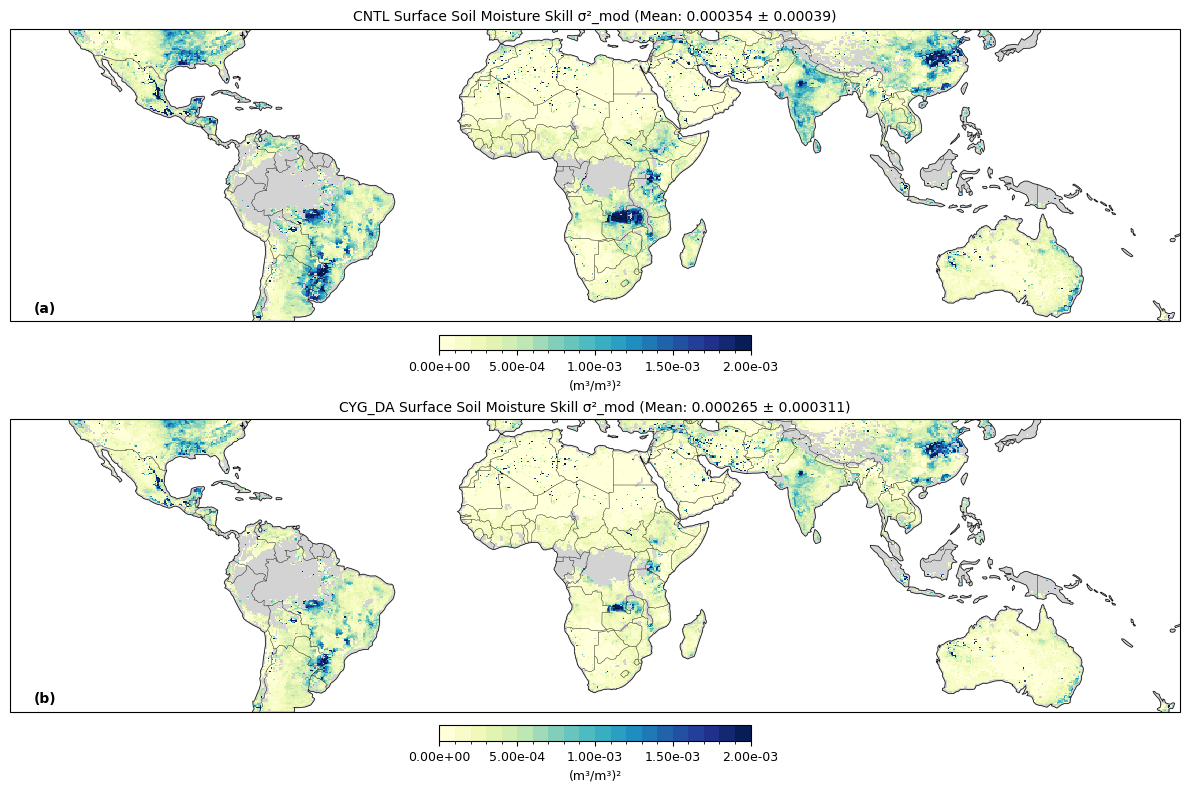

In [57]:
# Two-panel: CNTL vs CYG_DA sigma2_mod (same scale)
vals = [
    (S0["sigma2_mod"], 'CNTL Surface Soil Moisture Skill σ²_mod', '(a)'),
    (S1["sigma2_mod"], 'CYG_DA Surface Soil Moisture Skill σ²_mod', '(b)'),
]

lats_ease, lons_ease = load_ease_grid(); lats_row, lons_col = lats_ease[:,1], lons_ease[1,:]
lon_grid, lat_grid = np.meshgrid(lons_col, lats_row)
map_array_tmp = np.empty([lons.size, 3]); map_array_tmp.fill(np.nan); map_array_tmp[:,1] = lons.flatten(); map_array_tmp[:,2] = lats.flatten()

vmin, vmax = 0.0, 2e-3
edges = np.linspace(vmin, vmax, 21)
cmap = get_cmap('YlGnBu', len(edges) - 1)
norm = BoundaryNorm(edges, cmap.N)

fig, axes = plt.subplots(2, 1, figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
for ax, (data_grid, title, lab) in zip(axes, vals):
    data_grid = np.asarray(data_grid)
    data_grid = np.where(np.isfinite(data_grid), np.clip(data_grid, vmin, vmax), np.nan)
    data_flat = data_grid.flatten()
    mean_val = np.nanmean(data_flat); std_val = np.nanstd(data_flat)
    map_array_tmp[:,0] = data_flat
    grid = build_ease_grid_mapping(map_array_tmp, lats_row, lons_col)
    sc = ax.pcolormesh(lon_grid, lat_grid, grid, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    ax.add_feature(cfeature.LAND, color='lightgray', zorder=0)
    ax.set_extent(REGION_BOUNDS['cygnss'], crs=ccrs.PlateCarree())
    ax.set_title(f"{title} (Mean: {mean_val:.3g} ± {std_val:.3g})", fontsize=10)
    ax.text(0.02, 0.02, lab, transform=ax.transAxes, fontsize=10, fontweight='bold', va='bottom', ha='left')
    ax.tick_params(labelbottom=False, labelleft=False)
    cbar = fig.colorbar(sc, ax=ax, orientation='horizontal', pad=0.04, fraction=0.046)
    cbar.set_label('(m³/m³)²', fontsize=9)
    cbar.set_ticks(edges[::5])
    cbar.ax.set_xticklabels([f"{t:.2e}" for t in edges[::5]])
    cbar.ax.tick_params(labelsize=9)

plt.tight_layout()
plt.show()
